Name: Saman Akhtar USC ID: 9944619932

**Imports**

In [325]:
from sklearn import neighbors, metrics, preprocessing as pre
import pandas as pd
import glob
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import re
from scipy import interp
from itertools import cycle
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
import statsmodels.discrete.discrete_model as sm
from sklearn.preprocessing import  MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Time Series Classification

## (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/

Downloaded the dataset and did some manual cleaning like
removing /n from #cycling/dataset9.csv and #cycling/dataset14.csv. Formating #bending/dataset4.csv
Remaining cleaning done latter on, in the code.

1 b) The function to split dataset into training and testing dataset is written latter on

## (c) Feature Extraction Classification of time series 

### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc). 

The types of time-domain features used in time series classication are: 
1) Mean 2) Standard deviation 3) Maximum Value 4)Minimum 5) Kurtosis 6) Inter Quartile range 7) Skewness and others

### ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. 

In [326]:
# Use glob function and get list of all csv files in AReM folder
csv_files = glob.glob('../data/AReM/*/*.csv')

# Create func to sort by name and no associated with the file
def sort_file(full_file_path):
    activity_name, file = full_file_path.split('\\')[-2:]
    file_no = int(re.search('\d+', file)[0])
    return (activity_name, file_no)
csv_files = sorted(csv_files, key = sort_file)

len(csv_files)

88

In [327]:
# Creating df to store activity and file_no associated with csv file
act_file_df = pd.DataFrame(
    [sort_file(file)[0], sort_file(file)[1]] for file in csv_files
)
act_file_df.columns =  ['activity', 'file_no']
print(act_file_df)

    activity  file_no
0   bending1        1
1   bending1        2
2   bending1        3
3   bending1        4
4   bending1        5
..       ...      ...
83   walking       11
84   walking       12
85   walking       13
86   walking       14
87   walking       15

[88 rows x 2 columns]


In [328]:
# Create columns for stats_df containing 42 cols
new_col_names = []
for i in range(1, 7):
    new_col_names.extend(['min' + str(i), 'max' + str(i), 'mean' + str(i), 'median' + str(i),\
                     'standard deviation' + str(i), 'first quartile' + str(i), 'third quartile' + str(i)])


Not normalizing or standardizing the features.

In [329]:
#Creating empty pd containing 42 rows
stats_df = pd.DataFrame( columns = new_col_names)

# Iterating through each instance(88), finding stats , transposing it and finally appending to main stats_df
for file in csv_files:
    with open( file) as csv_file:
        rdline = csv_file.readlines()[5]
        csv_file.close
     #whitespace=32, comma=44   
        separator = rdline [1]
        
        # Read the file while skipping 5 rows and depending on separator store it in pd
        if separator == ' ' :
            file_df = pd.read_csv(file, skiprows = 5, sep='\s+', header = None)
        else:
            file_df = pd.read_csv( file, skiprows=5, header = None)
        file_df.columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        df = file_df.describe().drop('count').drop(columns = '# Columns: time').T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']]

        df_1 = pd.DataFrame(df.to_numpy().reshape(1,42), columns = new_col_names)

        stats_df = stats_df.append(df_1, ignore_index=True)

stats_df

min1   max1      mean1  median1  standard deviation1  first quartile1  \
0   37.25  45.00  40.624792    40.50             1.476967            39.25   
1   38.00  45.67  42.812812    42.50             1.435550            42.00   
2   35.00  47.40  43.954500    44.33             1.558835            43.00   
3   33.00  47.75  42.179813    43.50             3.670666            39.15   
4   33.00  45.75  41.678063    41.75             2.243490            41.33   
..    ...    ...        ...      ...                  ...              ...   
83  19.50  45.33  33.586875    34.25             4.650935            30.25   
84  19.75  45.50  34.322750    35.25             4.752477            31.00   
85  19.50  46.00  34.546229    35.25             4.842294            31.25   
86  23.50  46.25  34.873229    35.25             4.531720            31.75   
87  19.25  44.00  34.473188    35.00             4.796705            31.25   

    third quartile1  min2   max2     mean2  ...  standard deviation5  \
0           42.0000   0.0   1.30  0.358604  ...             2.188449   
1           43.6700   0.0   1.22  0.372438  ...             1.995255   
2           45.0000   0.0   1.70  0.426250  ...             1.999604   
3           45.0000   0.0   3.00  0.696042  ...             3.849448   
4           42.7500   0.0   2.83  0.535979  ...             2.411026   
..              ...   ...    ...       ...  ...                  ...   
83          37.0000   0.0  14.67  4.576562  ...             3.283983   
84          38.0000   0.0  13.47  4.456333  ...             3.119856   
85          37.8125   0.0  12.47  4.371958  ...             2.823124   
86          38.2500   0.0  14.82  4.380583  ...             3.131076   
87          38.0000   0.0  13.86  4.359312  ...             3.156320   

    first quartile5  third quartile5  min6   max6     mean6  median6  \
0           33.0000            36.00  0.00   1.92  0.570583     0.43   
1           32.0000            34.50  0.00   3.11  0.571083     0.43   
2           35.3625            36.50  0.00   1.79  0.493292     0.43   
3           30.4575            36.33  0.00   2.18  0.613521     0.50   
4           28.4575            31.25  0.00   1.79  0.383292     0.43   
..              ...              ...   ...    ...       ...      ...   
83          13.7300            18.25  0.00   8.32  3.259729     3.11   
84          13.5000            17.75  0.00   9.67  3.432562     3.20   
85          14.0000            17.75  0.00  10.00  3.338125     3.08   
86          13.7500            18.00  0.00   9.51  3.424646     3.27   
87          13.7300            17.75  0.43   9.00  3.340458     3.09   

    standard deviation6  first quartile6  third quartile6  
0              0.582915           0.0000           1.3000  
1              0.601010           0.0000           1.3000  
2              0.513506           0.0000           0.9400  
3              0.524317           0.0000           1.0000  
4              0.389164           0.0000           0.5000  
..                  ...              ...              ...  
83             1.640243           2.0500           4.3225  
84             1.732727           2.1575           4.5650  
85             1.656742           2.1600           4.3350  
86             1.690960           2.1700           4.5000  
87             1.699114           2.1200           4.3750  

[88 rows x 42 columns]

Dataframe containing time-domain features minimum, maximum, mean, median, stan-
dard deviation, first quartile, and third quartile for all of the 6 time series
in each instance

### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.


Standard deviation of each of the time-domain features extracted above from the data.

In [330]:
stat_std = stats_df.describe().loc['std']

Here using 1000 bootstrap samples

In [331]:
bs_estimate = pd.DataFrame(columns = list(stats_df.columns))
for i in range(1000):
    
    # Taking sample with replacement
    bs_reps = resample(stats_df, replace = True, n_samples = stats_df.shape[0])
    
    # Calculat sd for the sample
    bs_estimate = bs_estimate.append(bs_reps.apply(np.std, ddof=1, axis = 0), ignore_index=True) 

# getting 90 percentile of data , which is nothing but 90% confidence
percentile_data = bs_estimate.apply(np.percentile, args=([5, 95],), axis = 0)
con_interval = pd.Series([(round(percentile_data .loc[0,col], 2),\
                           round(percentile_data .loc[1,col],2)) for col in list(stats_df.columns)], index=list(stats_df.columns))    

In [332]:
pd.DataFrame(list(zip(np.round(stat_std,2), con_interval)), 
             index=stat_std.index, columns=['std', '90% Bootstrap CI'])

std 90% Bootstrap CI
min1                 9.57    (8.33, 10.72)
max1                 4.39     (3.32, 5.21)
mean1                5.34     (4.73, 5.86)
median1              5.44     (4.83, 5.98)
standard deviation1  1.77     (1.57, 1.94)
first quartile1      6.15     (5.56, 6.62)
third quartile1      5.14     (4.34, 5.77)
min2                 0.00       (0.0, 0.0)
max2                 5.06      (4.62, 5.4)
mean2                1.57      (1.39, 1.7)
median2              1.41     (1.24, 1.54)
standard deviation2  0.88      (0.8, 0.94)
first quartile2      0.95     (0.84, 1.04)
third quartile2      2.13     (1.89, 2.29)
min3                 2.96     (2.75, 3.11)
max3                 4.88     (4.16, 5.47)
mean3                4.01      (3.41, 4.5)
median3              4.04     (3.42, 4.56)
standard deviation3  0.95     (0.76, 1.14)
first quartile3      4.22     (3.63, 4.72)
third quartile3      4.17     (3.51, 4.71)
min4                 0.00       (0.0, 0.0)
max4                 2.18     (1.99, 2.36)
mean4                1.17     (1.08, 1.22)
median4              1.15      (1.06, 1.2)
standard deviation4  0.46     (0.42, 0.49)
first quartile4      0.84     (0.77, 0.89)
third quartile4      1.55     (1.43, 1.63)
min5                 6.12     (4.47, 7.48)
max5                 5.74     (4.69, 6.55)
mean5                5.68      (4.4, 6.72)
median5              5.81     (4.49, 6.87)
standard deviation5  1.02      (0.8, 1.23)
first quartile5      6.10      (4.73, 7.2)
third quartile5      5.53     (4.32, 6.52)
min6                 0.05      (0.0, 0.08)
max6                 2.52     (2.26, 2.76)
mean6                1.15     (1.06, 1.22)
median6              1.09      (1.0, 1.15)
standard deviation6  0.52     (0.48, 0.55)
first quartile6      0.76     (0.69, 0.81)
third quartile6      1.52       (1.4, 1.6)

The above table showing Standard deviation of each of the time-domain feature and there 90% Bootstrap CI

## 1(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data. 

In [413]:
# Function to separate training and testing data base on given requirement
def split_data(final_df = stats_df, act_name = 'bending', act_file_df = act_file_df):
    main_df = pd.concat([final_df, act_file_df], axis= 1)
    
    # Test Dataset: datasets 1,2 from bending 1 and bending 2
    test = main_df.loc[(main_df.activity.str.contains(act_name)) & (main_df.file_no.isin(['1','2']))].drop(columns = 'file_no')

    # Train Dataset: dataset3 to remaining count from bending1 and bending2 (including dataset3)
    train = main_df.loc[(main_df.activity.str.contains(act_name)) & (~main_df.file_no.isin(['1','2']))].drop(columns = 'file_no')

    # Test datasets : Earlier test from bending activity +  1,2,3 from other folders
    test = pd.concat([test, main_df.loc[(~main_df.activity.str.contains(act_name)) &\
                                            (main_df.file_no.isin(['1','2','3']))].drop(columns = 'file_no')])

    # Train dataset: Earlier train from bending activity + Dataset4 to remaining count from other folders (including dataset4)
    train = pd.concat([train, main_df.loc[(~main_df.activity.str.contains(act_name)) & (~main_df.file_no.isin(['1','2','3']))].drop(columns = 'file_no')])
    return train, test

 Splitting the time domain feature data to Training and testing data

In [334]:
train, test = split_data()
train

min1   max1      mean1  median1  standard deviation1  first quartile1  \
2   35.00  47.40  43.954500    44.33             1.558835            43.00   
3   33.00  47.75  42.179813    43.50             3.670666            39.15   
4   33.00  45.75  41.678063    41.75             2.243490            41.33   
5   37.00  48.00  43.454958    43.25             1.386098            42.50   
6   36.25  48.00  43.969125    44.50             1.618364            43.31   
..    ...    ...        ...      ...                  ...              ...   
83  19.50  45.33  33.586875    34.25             4.650935            30.25   
84  19.75  45.50  34.322750    35.25             4.752477            31.00   
85  19.50  46.00  34.546229    35.25             4.842294            31.25   
86  23.50  46.25  34.873229    35.25             4.531720            31.75   
87  19.25  44.00  34.473188    35.00             4.796705            31.25   

    third quartile1  min2   max2     mean2  ...  first quartile5  \
2           45.0000   0.0   1.70  0.426250  ...          35.3625   
3           45.0000   0.0   3.00  0.696042  ...          30.4575   
4           42.7500   0.0   2.83  0.535979  ...          28.4575   
5           45.0000   0.0   1.58  0.378083  ...          22.2500   
6           44.6700   0.0   1.50  0.413125  ...          20.5000   
..              ...   ...    ...       ...  ...              ...   
83          37.0000   0.0  14.67  4.576562  ...          13.7300   
84          38.0000   0.0  13.47  4.456333  ...          13.5000   
85          37.8125   0.0  12.47  4.371958  ...          14.0000   
86          38.2500   0.0  14.82  4.380583  ...          13.7500   
87          38.0000   0.0  13.86  4.359312  ...          13.7300   

    third quartile5  min6   max6     mean6  median6  standard deviation6  \
2             36.50  0.00   1.79  0.493292     0.43             0.513506   
3             36.33  0.00   2.18  0.613521     0.50             0.524317   
4             31.25  0.00   1.79  0.383292     0.43             0.389164   
5             24.00  0.00   5.26  0.679646     0.50             0.622534   
6             23.75  0.00   2.96  0.555313     0.49             0.487826   
..              ...   ...    ...       ...      ...                  ...   
83            18.25  0.00   8.32  3.259729     3.11             1.640243   
84            17.75  0.00   9.67  3.432562     3.20             1.732727   
85            17.75  0.00  10.00  3.338125     3.08             1.656742   
86            18.00  0.00   9.51  3.424646     3.27             1.690960   
87            17.75  0.43   9.00  3.340458     3.09             1.699114   

    first quartile6  third quartile6  activity  
2            0.0000           0.9400  bending1  
3            0.0000           1.0000  bending1  
4            0.0000           0.5000  bending1  
5            0.4300           0.8700  bending1  
6            0.0000           0.8300  bending1  
..              ...              ...       ...  
83           2.0500           4.3225   walking  
84           2.1575           4.5650   walking  
85           2.1600           4.3350   walking  
86           2.1700           4.5000   walking  
87           2.1200           4.3750   walking  

[69 rows x 43 columns]

In [335]:
test.shape

(19, 43)

### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)

In [336]:
# Creating training set containing bending col as 1 or 0
is_bendt = list(train.loc[:,'activity'].str.contains('bending').astype(int))
bend_train =  train.drop( 'activity', axis='columns', inplace=False)
bend_train['bending'] = is_bendt
bend_train.reset_index( drop =  True, inplace = True) 
bend_train

min1   max1      mean1  median1  standard deviation1  first quartile1  \
0   35.00  47.40  43.954500    44.33             1.558835            43.00   
1   33.00  47.75  42.179813    43.50             3.670666            39.15   
2   33.00  45.75  41.678063    41.75             2.243490            41.33   
3   37.00  48.00  43.454958    43.25             1.386098            42.50   
4   36.25  48.00  43.969125    44.50             1.618364            43.31   
..    ...    ...        ...      ...                  ...              ...   
64  19.50  45.33  33.586875    34.25             4.650935            30.25   
65  19.75  45.50  34.322750    35.25             4.752477            31.00   
66  19.50  46.00  34.546229    35.25             4.842294            31.25   
67  23.50  46.25  34.873229    35.25             4.531720            31.75   
68  19.25  44.00  34.473188    35.00             4.796705            31.25   

    third quartile1  min2   max2     mean2  ...  first quartile5  \
0           45.0000   0.0   1.70  0.426250  ...          35.3625   
1           45.0000   0.0   3.00  0.696042  ...          30.4575   
2           42.7500   0.0   2.83  0.535979  ...          28.4575   
3           45.0000   0.0   1.58  0.378083  ...          22.2500   
4           44.6700   0.0   1.50  0.413125  ...          20.5000   
..              ...   ...    ...       ...  ...              ...   
64          37.0000   0.0  14.67  4.576562  ...          13.7300   
65          38.0000   0.0  13.47  4.456333  ...          13.5000   
66          37.8125   0.0  12.47  4.371958  ...          14.0000   
67          38.2500   0.0  14.82  4.380583  ...          13.7500   
68          38.0000   0.0  13.86  4.359312  ...          13.7300   

    third quartile5  min6   max6     mean6  median6  standard deviation6  \
0             36.50  0.00   1.79  0.493292     0.43             0.513506   
1             36.33  0.00   2.18  0.613521     0.50             0.524317   
2             31.25  0.00   1.79  0.383292     0.43             0.389164   
3             24.00  0.00   5.26  0.679646     0.50             0.622534   
4             23.75  0.00   2.96  0.555313     0.49             0.487826   
..              ...   ...    ...       ...      ...                  ...   
64            18.25  0.00   8.32  3.259729     3.11             1.640243   
65            17.75  0.00   9.67  3.432562     3.20             1.732727   
66            17.75  0.00  10.00  3.338125     3.08             1.656742   
67            18.00  0.00   9.51  3.424646     3.27             1.690960   
68            17.75  0.43   9.00  3.340458     3.09             1.699114   

    first quartile6  third quartile6  bending  
0            0.0000           0.9400        1  
1            0.0000           1.0000        1  
2            0.0000           0.5000        1  
3            0.4300           0.8700        1  
4            0.0000           0.8300        1  
..              ...              ...      ...  
64           2.0500           4.3225        0  
65           2.1575           4.5650        0  
66           2.1600           4.3350        0  
67           2.1700           4.5000        0  
68           2.1200           4.3750        0  

[69 rows x 43 columns]

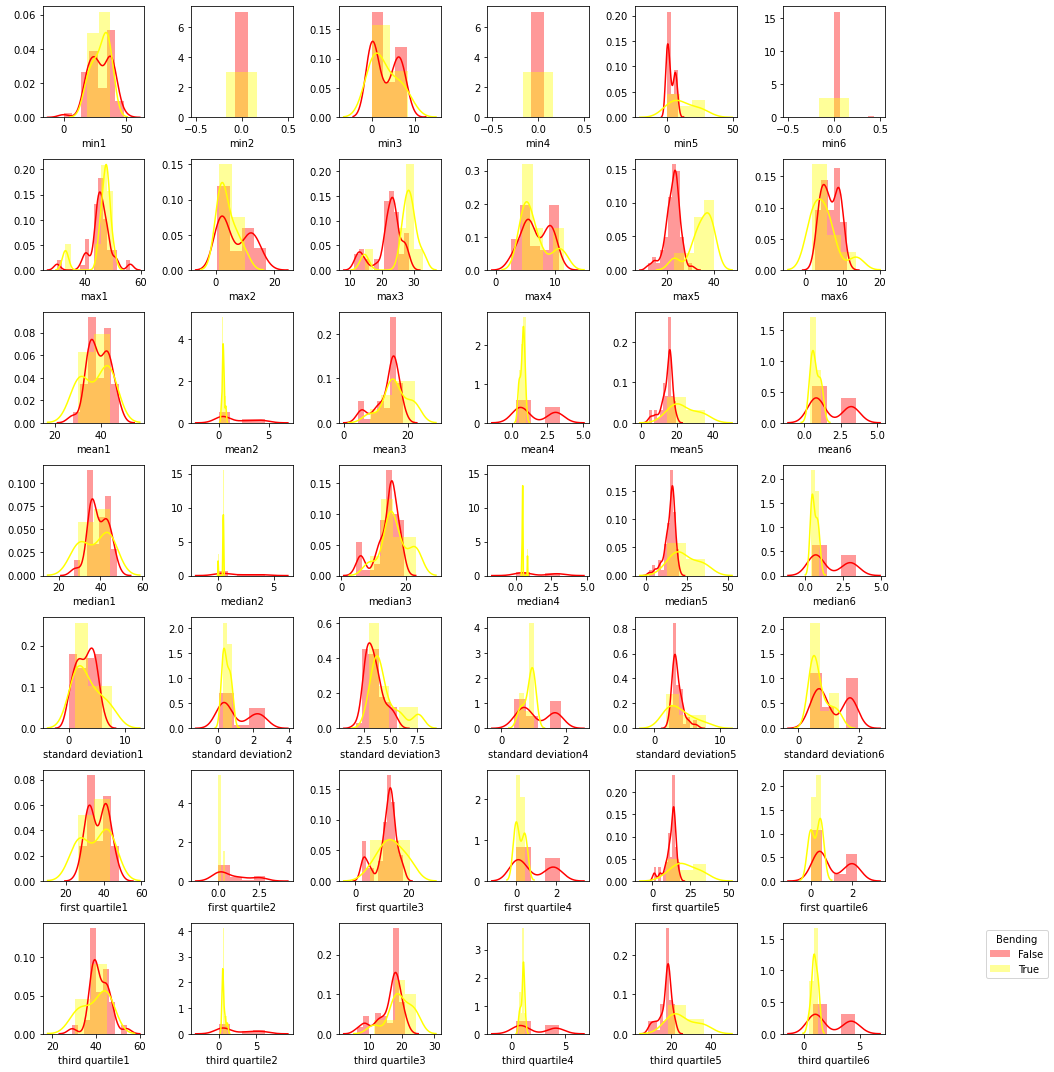

In [414]:
warnings.filterwarnings('ignore')
cols = ['min','max','mean','median','standard deviation', 'first quartile', 'third quartile' ]
plt.figure(figsize=(15,15))
for i, col in enumerate(cols, start = 1):
    for j in range(1,7):    
        plt.subplot(len(cols), 6, 6*i+j-6)
        sns.distplot(bend_train.loc[bend_train['bending']== 0][col + str(j)], kde = True,\
                     color="red", label="False")
        sns.distplot(bend_train.loc[bend_train['bending']== 1][col + str(j)] , kde = True,\
                     color="yellow", label="True")
plt.legend(title = 'Bending',loc=(2.0,0.5))
plt.tight_layout()

I will be using mixture of distribution(widely and densely), Hence choosing Min,  Max, third quartile.

## Binary Classification Using Logistic Regression

Creating a column bending(both bending 1 and bending 2), which containing 1 value if the activity is bending  else it contains 0.

In [337]:
bend_trainX = bend_train.drop(columns = 'bending')
bend_trainY = bend_train['bending']

In [338]:
# Creating testing data set containing bending col as True or False
is_bend = list(test.loc[:,'activity'].str.contains('bending').astype(int))
bend_test =  test.drop( 'activity', axis='columns', inplace=False)
bend_test = test.copy()
bend_test['bending'] = is_bend
bend_test.reset_index(drop =  True,  inplace = True) 
bend_test

min1   max1      mean1  median1  standard deviation1  first quartile1  \
0   37.25  45.00  40.624792   40.500             1.476967          39.2500   
1   38.00  45.67  42.812812   42.500             1.435550          42.0000   
2   12.75  51.00  24.562958   24.250             3.737514          23.1875   
3    0.00  42.75  27.464604   28.000             3.583582          25.5000   
4   24.25  45.00  37.177042   36.250             3.581301          34.5000   
5   28.75  44.75  37.561188   36.875             3.226507          35.2500   
6   22.00  44.67  37.058708   36.000             3.710180          34.5000   
7   23.50  30.00  27.716375   27.500             1.442253          27.0000   
8   24.75  48.33  44.182937   48.000             7.495615          48.0000   
9   48.00  48.25  48.004167   48.000             0.032038          48.0000   
10  33.25  48.00  42.363563   43.000             2.068247          42.0000   
11  37.00  50.75  45.917667   45.635             1.089027          45.0000   
12  44.50  46.75  45.239667   45.000             0.429915          45.0000   
13  33.33  48.00  44.334729   45.000             2.476940          42.2500   
14  35.50  46.25  43.174938   43.670             1.989052          42.5000   
15  32.75  47.00  42.760563   44.500             3.398919          41.3300   
16  19.33  43.50  34.227771   35.500             4.889576          30.5000   
17  12.50  45.00  33.509729   34.125             4.850923          30.5000   
18  15.00  46.75  34.660583   35.000             5.315110          31.0000   

    third quartile1  min2   max2     mean2  ...  third quartile5  min6  max6  \
0           42.0000   0.0   1.30  0.358604  ...          36.0000   0.0  1.92   
1           43.6700   0.0   1.22  0.372438  ...          34.5000   0.0  3.11   
2           26.5000   0.0   6.87  0.590833  ...          27.0000   0.0  4.97   
3           30.0000   0.0   7.76  0.449708  ...          20.7500   0.0  6.76   
4           40.2500   0.0   8.58  2.374208  ...          21.7500   0.0  9.34   
5           40.2500   0.0   9.91  2.080688  ...          21.5000   0.0  9.62   
6           40.0625   0.0  14.17  2.438146  ...          21.0000   0.0  8.55   
7           29.0000   0.0   1.79  0.363688  ...          10.7500   0.0  4.50   
8           48.0000   0.0   3.11  0.101875  ...           5.5425   0.0  3.91   
9           48.0000   0.0   0.43  0.007167  ...          10.0000   0.0  2.50   
10          43.5000   0.0   4.44  0.492563  ...          17.6900   0.0  6.02   
11          46.5000   0.0   4.87  0.324542  ...          21.0000   0.0  7.22   
12          45.3300   0.0   1.00  0.172958  ...          21.0000   0.0  8.20   
13          46.5000   0.0   3.90  0.432958  ...          17.7500   0.0  5.02   
14          44.5000   0.0   2.12  0.506583  ...          16.5000   0.0  5.72   
15          45.3725   0.0   3.34  0.486167  ...          18.5650   0.0  5.73   
16          37.7500   0.0  14.50  3.995729  ...          18.6700   0.0  9.74   
17          36.7500   0.0  13.05  4.450771  ...          18.7500   0.0  8.96   
18          38.2500   0.0  13.44  4.200896  ...          18.5000   0.0  8.99   

       mean6  median6  standard deviation6  first quartile6  third quartile6  \
0   0.570583    0.430             0.582915           0.0000            1.300   
1   0.571083    0.430             0.601010           0.0000            1.300   
2   0.700188    0.500             0.693720           0.4300            0.870   
3   1.122125    0.830             1.012342           0.4700            1.300   
4   2.921729    2.500             1.852600           1.5000            3.900   
5   2.765896    2.450             1.769203           1.4100            3.770   
6   2.983750    2.570             1.815730           1.5000            4.150   
7   0.734271    0.710             0.613688           0.4300            1.000   
8   0.692771    0.500             0.675781           0.3225            0.940   
9   0.641229    0.500             0.388372 

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. 


In [339]:
bend_testX = bend_test.drop(columns = 'bending')
bend_testY = bend_test['bending']

Scatterplot of the 1,2 and 6 column of the 3 important time-domain features 

In [340]:
scatter_lst = [col + str(i) for i in [1,2,6] for col in ['min' ,'max','third quartile']]
scatter_df = bend_train[scatter_lst + ['bending']]
scatter_df

min1   max1  third quartile1  min2   max2  third quartile2  min6   max6  \
0   35.00  47.40          45.0000   0.0   1.70           0.5000  0.00   1.79   
1   33.00  47.75          45.0000   0.0   3.00           1.1200  0.00   2.18   
2   33.00  45.75          42.7500   0.0   2.83           0.7100  0.00   1.79   
3   37.00  48.00          45.0000   0.0   1.58           0.5000  0.00   5.26   
4   36.25  48.00          44.6700   0.0   1.50           0.5000  0.00   2.96   
..    ...    ...              ...   ...    ...              ...   ...    ...   
64  19.50  45.33          37.0000   0.0  14.67           6.1050  0.00   8.32   
65  19.75  45.50          38.0000   0.0  13.47           5.9700  0.00   9.67   
66  19.50  46.00          37.8125   0.0  12.47           5.8000  0.00  10.00   
67  23.50  46.25          38.2500   0.0  14.82           5.9325  0.00   9.51   
68  19.25  44.00          38.0000   0.0  13.86           5.9000  0.43   9.00   

    third quartile6  bending  
0            0.9400        1  
1            1.0000        1  
2            0.5000        1  
3            0.8700        1  
4            0.8300        1  
..              ...      ...  
64           4.3225        0  
65           4.5650        0  
66           4.3350        0  
67           4.5000        0  
68           4.3750        0  

[69 rows x 10 columns]

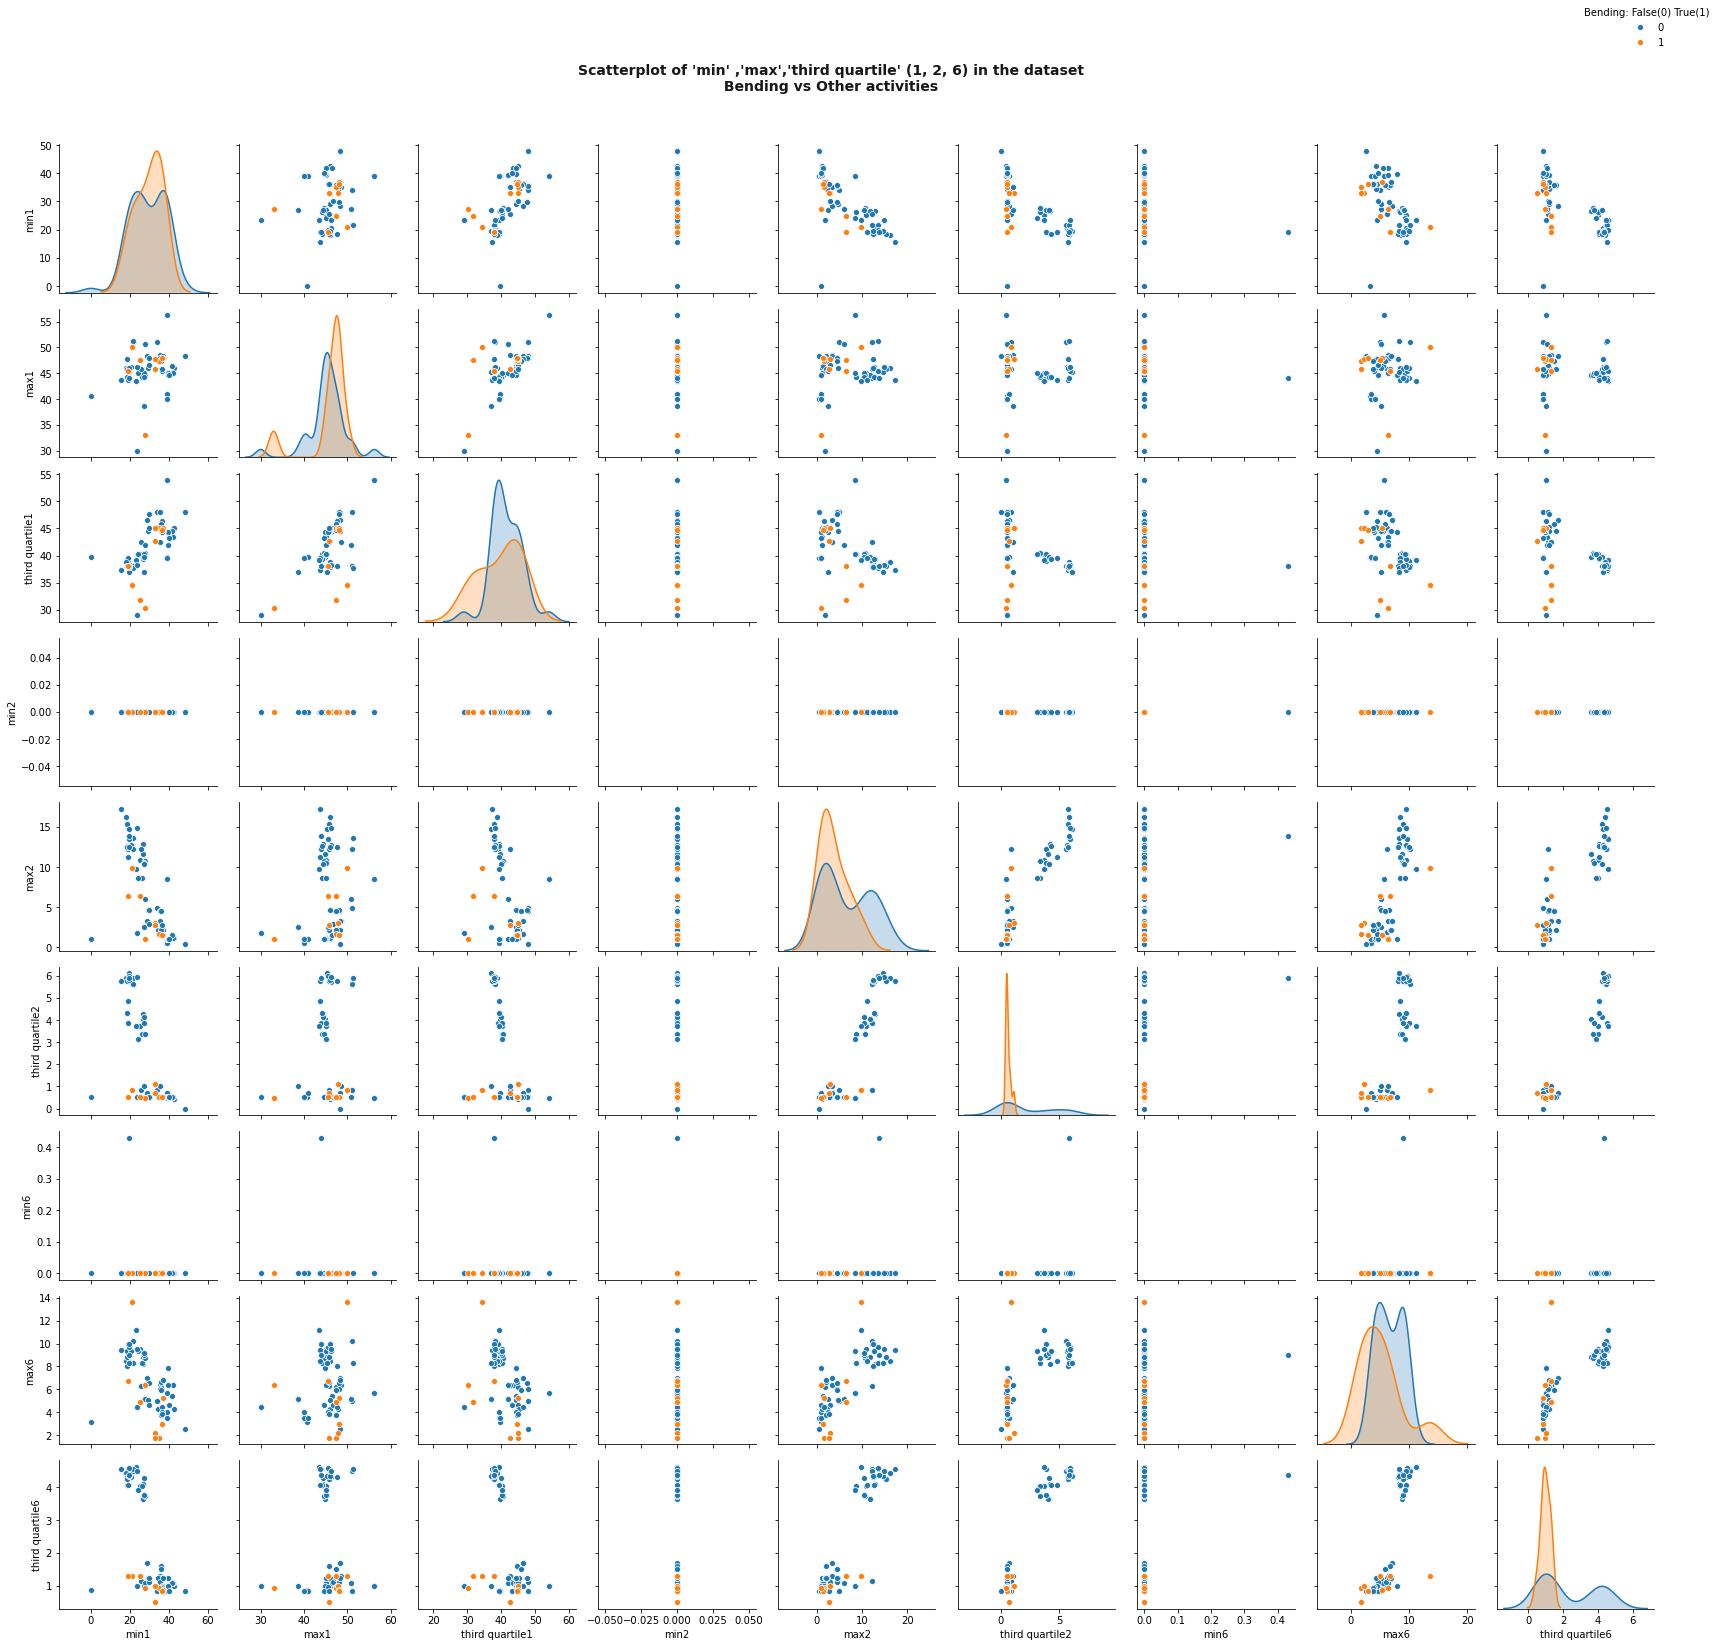

In [341]:
warnings.filterwarnings('ignore')
figure = sns.pairplot(scatter_df, hue = 'bending')
plt.tight_layout()
plt.subplots_adjust(top = .93 )
figure._legend.set_bbox_to_anchor((1.03, 1))
figure.fig.suptitle("Scatterplot of 'min' ,'max','third quartile' (1, 2, 6) in the dataset\n Bending vs Other activities ", fontsize = 14, alpha = 0.9, weight = 'bold')
figure._legend.set_title('Bending: False(0) True(1)')
plt.show()

### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i 

In [342]:
# Create columns for stats_df containing 42 cols

def create_col_name(stop , start = 1):
    new_col_names = []
    for i in range(start, stop):
        
        # Creating column for selected features on c iv)
        new_col_names.extend(['min' + str(i) ,'max'+ str(i),'third quartile'+ str(i)])
#         new_col_names.extend(['min' + str(i), 'max' + str(i), 'mean' + str(i), 'median' + str(i),\
#                          'standard deviation' + str(i), 'first quartile' + str(i), 'third quartile' + str(i)])
    return new_col_names

#col_names = np.arr
def break_df(length, csv_files = csv_files):
    col_names = np.array(['min', 'max','75%'])
    
    # Creating empty pd containing (length * 6) * 3 rows
    new_col_names = create_col_name((length * 6) + 1)
    stats_df = pd.DataFrame( columns = new_col_names)

    # Iterating through each instance(88), finding stats , transposing it and finally appending to main stats_df
    for file in csv_files:
        with open( file) as csv_file:
            read_line = csv_file.readlines()[5]
            csv_file.close
            separator = read_line [1]

            # Read the file while skipping 5 rows and depending on separator store it in pd
            if separator == ' ' :
                file_df = pd.read_csv(file, skiprows = 5, sep='\s+', header = None)
            else:
                file_df = pd.read_csv( file, skiprows = 5, header = None)
            file_df.columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

            
            file_df.drop(columns = '# Columns: time', inplace = True)
            group_dfs = np.array_split(file_df, length)

            main_df = pd.DataFrame()
            for i, part_df in enumerate(group_dfs):
                part_df.reset_index(drop =  True,  inplace = True) 
                main_df = pd.concat([main_df, part_df], axis=1 )
            df =  main_df.describe().drop('count').T[col_names]
            desc_df = pd.DataFrame(df.to_numpy().reshape(1, len(col_names) *6 *length), columns = new_col_names)
            stats_df = stats_df.append(desc_df, ignore_index = True)
        
    return stats_df


In [343]:
# Breaking data in length of 2
two_df = break_df(2)
two_df

min1   max1  third quartile1  min2   max2  third quartile2   min3   max3  \
0   38.00  42.33          42.0000   0.0   1.22           0.5000   4.00  25.67   
1   41.75  44.25          43.3300   0.0   0.94           0.5000   7.00  25.33   
2   36.50  46.50          45.0000   0.0   1.50           0.5000  14.25  29.25   
3   33.75  47.75          45.2500   0.0   3.00           1.0000  11.00  30.00   
4   33.00  45.75          44.2500   0.0   2.83           0.8300   3.00  28.25   
..    ...    ...              ...   ...    ...              ...    ...    ...   
83  19.50  45.00          36.8125   0.0  11.78           5.8700   7.33  22.75   
84  20.33  44.50          37.7500   0.0  13.47           6.5050   6.25  22.00   
85  19.50  43.33          37.5000   0.0  12.47           6.0300   7.00  22.67   
86  24.33  44.00          37.8125   0.0  14.82           5.4550   6.67  24.25   
87  19.25  44.00          38.2500   0.0  13.86           5.4175   6.00  21.00   

    third quartile3  min4  ...  third quartile9  min10  max10  \
0           20.2500  0.00  ...            24.00   0.00   5.50   
1           21.5000  0.00  ...            23.00   0.00   5.76   
2           24.0000  0.00  ...            24.00   0.00   4.44   
3           24.8125  0.00  ...            24.00   0.00   5.15   
4           24.0000  0.00  ...            20.75   0.00   2.35   
..              ...   ...  ...              ...    ...    ...   
83          17.3125  0.00  ...            17.27   0.00   9.00   
84          17.0000  0.43  ...            17.00   0.00   7.46   
85          17.2500  0.00  ...            17.00   0.00   8.22   
86          17.0625  0.00  ...            17.25   0.43   9.90   
87          17.5000  0.00  ...            17.25   0.00   8.38   

    third quartile10  min11  max11  third quartile11  min12  max12  \
0             1.4250  27.25  38.25           36.5000   0.00   1.92   
1             1.5000  27.67  38.50           33.7500   0.00   3.11   
2             0.7100  29.00  38.25           36.2500   0.00   1.50   
3             1.4800  20.00  38.50           33.7500   0.00   2.18   
4             0.8300  26.00  36.00           30.5625   0.00   1.50   
..               ...    ...    ...               ...    ...    ...   
83            4.3200   6.33  23.33           18.0625   0.43   8.32   
84            4.0600   6.33  23.25           17.7500   0.00   9.67   
85            3.9775   7.00  21.33           17.2500   0.00   8.64   
86            4.1500   5.50  23.50           18.0625   0.00   9.51   
87            3.9600   5.75  23.25           17.5000   0.43   8.26   

    third quartile12  
0             0.9400  
1             0.8700  
2             0.7100  
3             0.8700  
4             0.5000  
..               ...  
83            4.4525  
84            4.3950  
85            4.5125  
86            4.4525  
87            4.3050  

[88 rows x 36 columns]

In [344]:
# Function to create column by activity name and add 0, 1 value according to the activity.
# Finally dividing training data to trainX and trainY
def adding_activity_train( train = train, activity_name ='bending'):
    # Creating training set containing activity name col as True or False
    is_act = list(train.loc[:,'activity'].str.contains(activity_name).astype(int))
    act_train =  train.drop( 'activity', axis='columns', inplace=False)
    act_train[activity_name] = is_act
    act_train.reset_index( drop =  True, inplace = True) 
    return act_train

# Function to create column by activity name and add 0, 1 value according to the activity.
def adding_activity_test( test = train, activity_name = 'bending'):
    # Creating testing data set containing activity col as True or False
    is_act = list(test.loc[:,'activity'].str.contains(activity_name).astype(int))
    act_test =  test.drop( 'activity', axis='columns', inplace=False)
    act_test[activity_name] = is_act
    act_test.reset_index(drop =  True,  inplace = True) 
    return act_test

# Function to divide training/testing data to trainX/testX and trainX/testY based on activity_name
def split_input_output(data, activity_name = 'bending'):
    
    #Creating a column activity, which containing 1 value if
    # the activity is bending  else it contains 0.
    act_dataX = data.drop(columns = activity_name)
    act_dataY = data[activity_name]
    return act_dataX, act_dataY
    

In [345]:
# Splitting the whole dataset to training and testing data
two_train, two_test = split_data(two_df)

In [346]:
scatter_two_train = adding_activity_train(two_train)
scatter_two_train

min1   max1  third quartile1  min2   max2  third quartile2   min3   max3  \
0   36.50  46.50          45.0000   0.0   1.50           0.5000  14.25  29.25   
1   33.75  47.75          45.2500   0.0   3.00           1.0000  11.00  30.00   
2   33.00  45.75          44.2500   0.0   2.83           0.8300   3.00  28.25   
3   39.00  48.00          45.0000   0.0   1.30           0.5000   6.25  27.00   
4   36.67  45.00          44.5000   0.0   1.30           0.5000   4.00  26.33   
..    ...    ...              ...   ...    ...              ...    ...    ...   
64  19.50  45.00          36.8125   0.0  11.78           5.8700   7.33  22.75   
65  20.33  44.50          37.7500   0.0  13.47           6.5050   6.25  22.00   
66  19.50  43.33          37.5000   0.0  12.47           6.0300   7.00  22.67   
67  24.33  44.00          37.8125   0.0  14.82           5.4550   6.67  24.25   
68  19.25  44.00          38.2500   0.0  13.86           5.4175   6.00  21.00   

    third quartile3  min4  ...  min10  max10  third quartile10  min11  max11  \
0           24.0000  0.00  ...   0.00   4.44            0.7100  29.00  38.25   
1           24.8125  0.00  ...   0.00   5.15            1.4800  20.00  38.50   
2           24.0000  0.00  ...   0.00   2.35            0.8300  26.00  36.00   
3           20.0000  0.00  ...   0.00   5.21            0.8225   8.00  26.00   
4           18.0000  0.00  ...   0.00   3.56            0.8875  13.75  26.00   
..              ...   ...  ...    ...    ...               ...    ...    ...   
64          17.3125  0.00  ...   0.00   9.00            4.3200   6.33  23.33   
65          17.0000  0.43  ...   0.00   7.46            4.0600   6.33  23.25   
66          17.2500  0.00  ...   0.00   8.22            3.9775   7.00  21.33   
67          17.0625  0.00  ...   0.43   9.90            4.1500   5.50  23.50   
68          17.5000  0.00  ...   0.00   8.38            3.9600   5.75  23.25   

    third quartile11  min12  max12  third quartile12  bending  
0            36.2500   0.00   1.50            0.7100        1  
1            33.7500   0.00   2.18            0.8700        1  
2            30.5625   0.00   1.50            0.5000        1  
3            23.7500   0.00   4.06            0.7100        1  
4            23.5000   0.00   2.96            0.8300        1  
..               ...    ...    ...               ...      ...  
64           18.0625   0.43   8.32            4.4525        0  
65           17.7500   0.00   9.67            4.3950        0  
66           17.2500   0.00   8.64            4.5125        0  
67           18.0625   0.00   9.51            4.4525        0  
68           17.5000   0.43   8.26            4.3050        0  

[69 rows x 37 columns]

In [347]:
# Creatinf df of 3 feature selected before of col ending with 1, 2, 12 
scatter_lst = [col + str(i) for i in [1,2,12] for col in ['min' ,'max','third quartile']]#['mean' ,'median','standard deviation']]
scatter_two_train = scatter_two_train[scatter_lst + ['bending']]
scatter_two_train

min1   max1  third quartile1  min2   max2  third quartile2  min12  max12  \
0   36.50  46.50          45.0000   0.0   1.50           0.5000   0.00   1.50   
1   33.75  47.75          45.2500   0.0   3.00           1.0000   0.00   2.18   
2   33.00  45.75          44.2500   0.0   2.83           0.8300   0.00   1.50   
3   39.00  48.00          45.0000   0.0   1.30           0.5000   0.00   4.06   
4   36.67  45.00          44.5000   0.0   1.30           0.5000   0.00   2.96   
..    ...    ...              ...   ...    ...              ...    ...    ...   
64  19.50  45.00          36.8125   0.0  11.78           5.8700   0.43   8.32   
65  20.33  44.50          37.7500   0.0  13.47           6.5050   0.00   9.67   
66  19.50  43.33          37.5000   0.0  12.47           6.0300   0.00   8.64   
67  24.33  44.00          37.8125   0.0  14.82           5.4550   0.00   9.51   
68  19.25  44.00          38.2500   0.0  13.86           5.4175   0.43   8.26   

    third quartile12  bending  
0             0.7100        1  
1             0.8700        1  
2             0.5000        1  
3             0.7100        1  
4             0.8300        1  
..               ...      ...  
64            4.4525        0  
65            4.3950        0  
66            4.5125        0  
67            4.4525        0  
68            4.3050        0  

[69 rows x 10 columns]

Scatterplot of the 1,2 and 12 column of the 3 important time-domain features 

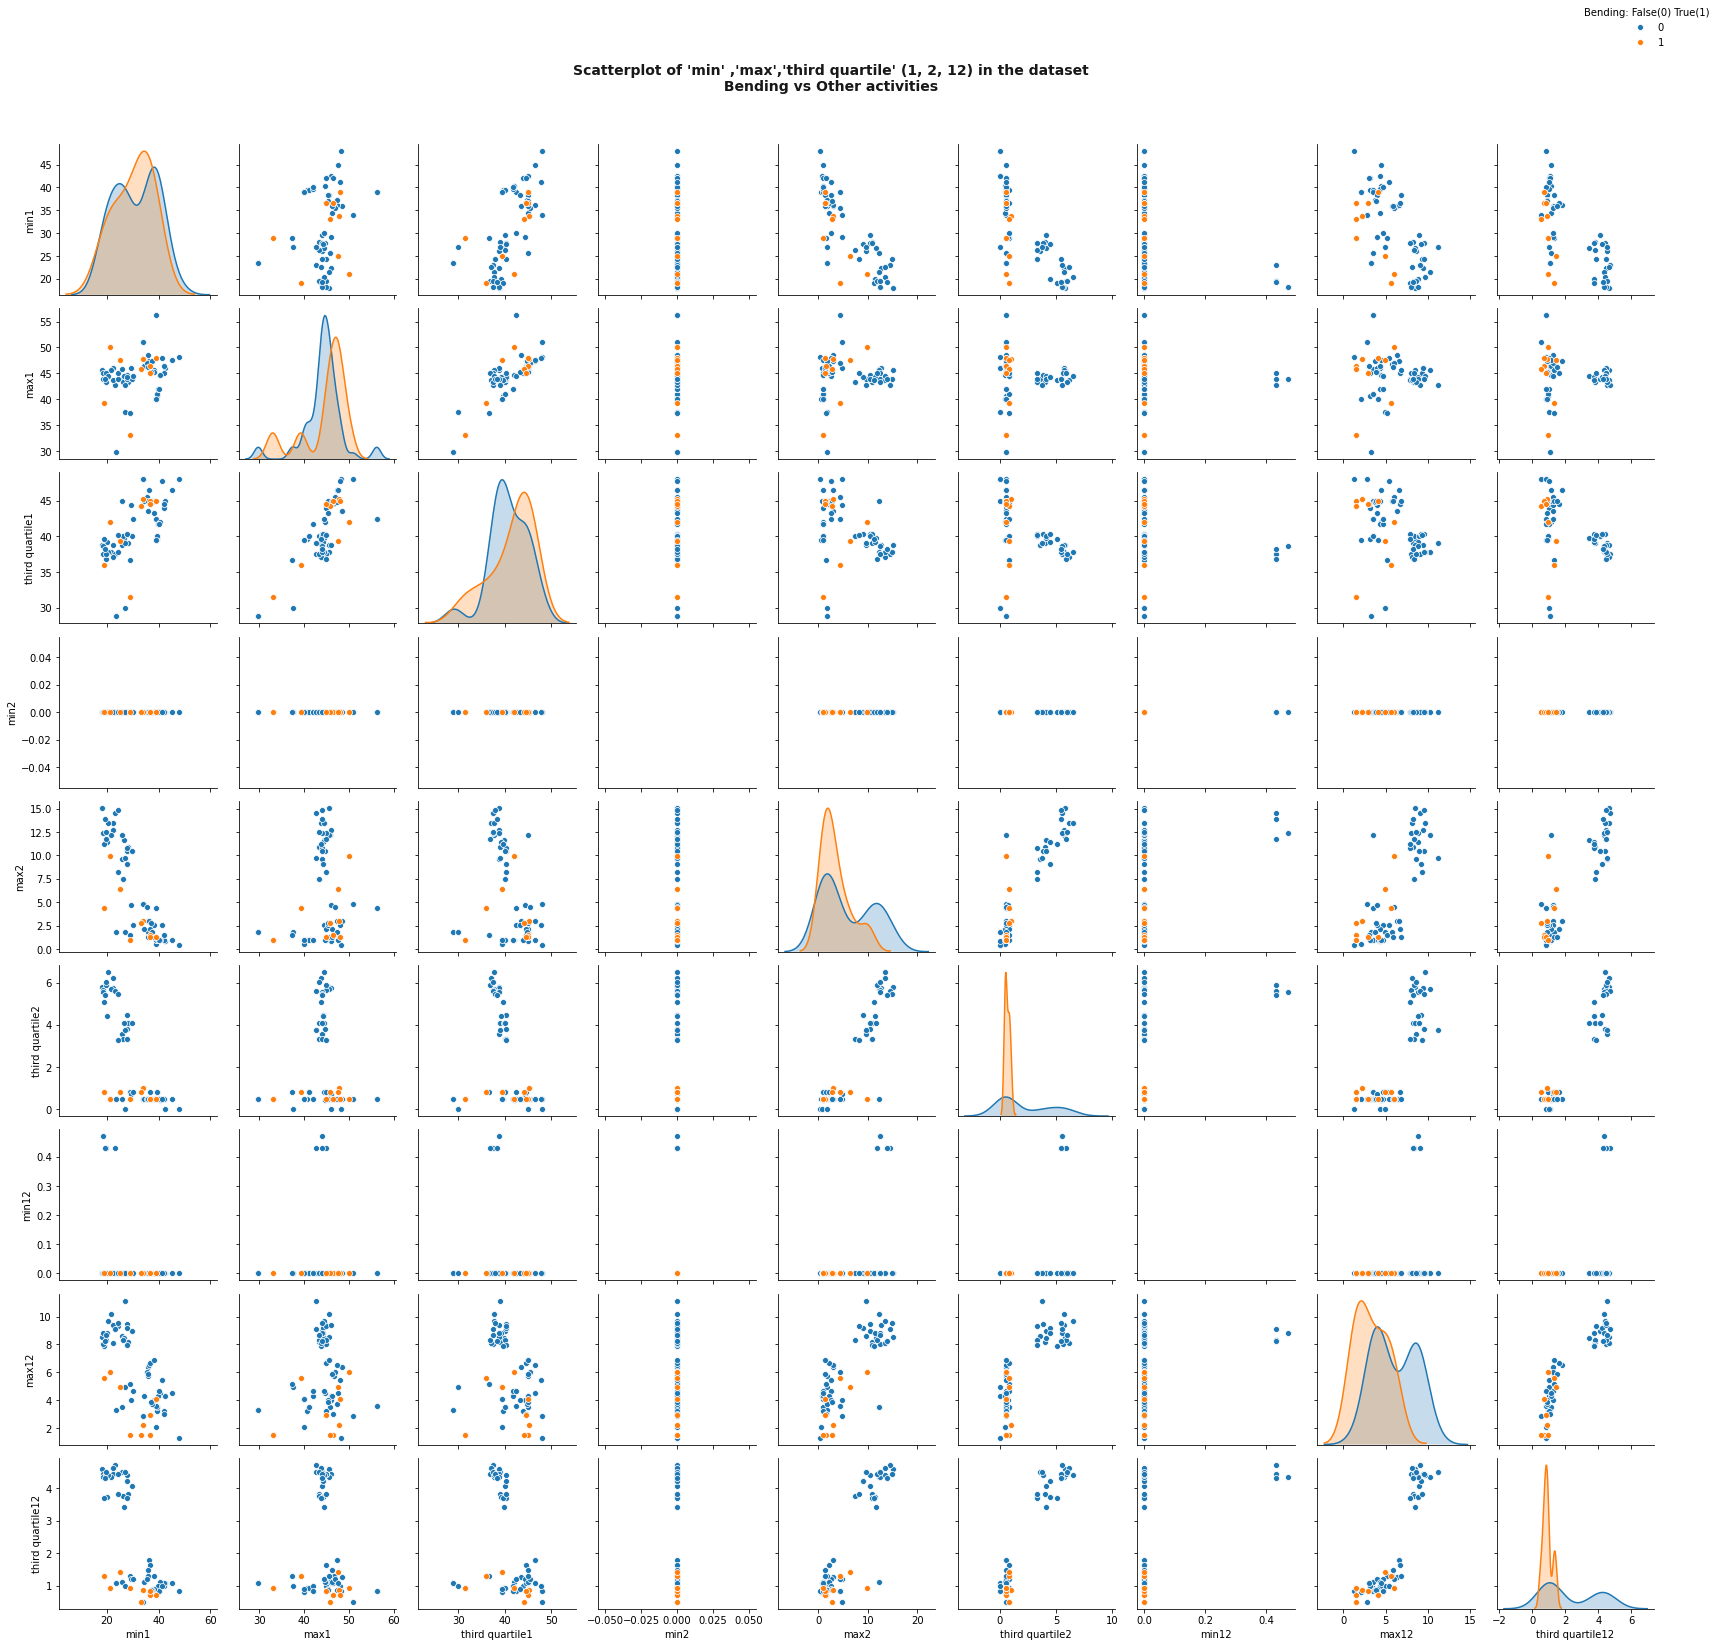

In [348]:
warnings.filterwarnings('ignore')
figure = sns.pairplot(scatter_two_train, hue = 'bending')
plt.tight_layout()
plt.subplots_adjust(top = .93 )
figure._legend.set_bbox_to_anchor((1.03, 1))
figure.fig.suptitle("Scatterplot of 'min' ,'max','third quartile' (1, 2, 12) in the dataset\n Bending vs Other activities ", fontsize = 14, alpha = 0.9, weight = 'bold')
figure._legend.set_title('Bending: False(0) True(1)')
plt.show()

There is not much difference between the above pairplot and the one in d i).The only small difference is the above graph is slightly more sparse compare to d i).

### iii) Break each time series in your training set into l ∈ { 1 , 2 , . . . , 20 } time series of approximately equal length and use logistic regression 5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. 6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair ( l, p ), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. 7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratifiedcross validation. Research what it means and use it if needed. In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic re- gression

Each time series is broken to various length (1-20). Then time domain feature is extracted. Whole time domain  dataframe is divided to training and testing dataset. Using cross validation (5 fold) training data set divided into training and validation data set. RFCVE is used for feature selection .
In logicRegression, C value  is kept high to remove effect of regularization.

In [349]:
warnings.filterwarnings('ignore')
final_f1 = np.array([])
final_accuracy = np.array([])
i_val =  np.array([])

# Break time series in various len
for i in range( 1, 21):
    split_df =  break_df(i)
    i_val = np.append(i_val, i)
 
    # Splitting the whole dataset to training and testing data
    split_train, split_test = split_data(split_df)
    split_train = adding_activity_train(split_train)
    X_train , Y_train = split_input_output(split_train)
    logic_reg = LogisticRegression( C=10000 ,max_iter= 10, n_jobs =-1 )
    st_kcv = StratifiedKFold(n_splits = 5, shuffle = False)
    f1_scores = np.array([])
    accuracy = np.array([])
    feature_lst = []
    
    # Generate indices to split data into training and test set.
    for train_index, test_index in st_kcv.split(X_train , Y_train):
        rfecv = RFECV(estimator = logic_reg, step=1, cv = StratifiedKFold(n_splits = 5, shuffle = False), scoring = 'accuracy')
        fit_rfecv = rfecv.fit(X_train.loc[train_index], Y_train[train_index])
        
        # Selecting columns containg best features
        selected_feat_lst = X_train.columns[fit_rfecv.support_]
        X = X_train.loc[train_index][selected_feat_lst]
        X_valid = X_train.loc[test_index][selected_feat_lst]
       
        # Fitting again with the best features
        fit_agn = logic_reg.fit(X, Y_train[train_index])
        y_pred = logic_reg.predict(X_valid)
        accuracy = np.append(accuracy, logic_reg.score(X_valid, Y_train[test_index]))
        #print( "for i ", i," f1 ",f1_score(Y_train[test_index], y_pred, average='weighted') )
        f1_scores = np.append(f1_scores,f1_score(Y_train[test_index], y_pred, average = 'weighted'))
   
    final_f1 = np.append(final_f1, np.mean(f1_scores))
    index_f1 = np.argmax(f1_scores)
    final_accuracy = np.append(final_accuracy, np.mean(accuracy))
  


In [350]:
# Creating dataframe to find best l
res_df = pd.DataFrame(np.column_stack([i_val, final_accuracy, final_f1]),\
                              columns=[ 'l','Accuracy',  'F1 score', ])
res_df

l  Accuracy  F1 score
0    1.0  0.985714  0.986832
1    2.0  0.971429  0.970451
2    3.0  0.985714  0.983619
3    4.0  0.913187  0.886330
4    5.0  0.927473  0.906901
5    6.0  0.957143  0.955048
6    7.0  0.941758  0.928088
7    8.0  0.957143  0.955048
8    9.0  0.957143  0.954070
9   10.0  0.927473  0.911707
10  11.0  0.971429  0.967238
11  12.0  0.941758  0.919092
12  13.0  0.971429  0.967238
13  14.0  0.971429  0.967238
14  15.0  0.927473  0.915897
15  16.0  0.970330  0.960850
16  17.0  0.985714  0.983619
17  18.0  0.970330  0.960850
18  19.0  0.941758  0.928088
19  20.0  0.956044  0.935473

from the above table, Accuracy of l 1 and  F1 score of l: (0.987 ) is the highest: 
Hence will be choosing l as 1

In [351]:
# Getting index of best f1 score
ind = np.argmax(res_df['F1 score'])
best_l = (res_df['l'][ind]).astype(int)
print("The value of best l is: ", best_l, " Having best f1 score: ",res_df['F1 score'][ind], " and \
accuracy is:", res_df['Accuracy'][ind])

The value of best l is:  1  Having best f1 score:  0.986832298136646  and accuracy is: 0.9857142857142858


Logistic regression with l = 1

In [352]:
# Using best l
split_df =  break_df(best_l)

# Splitting the whole dataset to training and testing data
split_train, split_test = split_data(split_df)
split_train = adding_activity_train(split_train)
# Spliting train data into predictor and response
X_train , Y_train = split_input_output(split_train)

# Spliting test data into predictor and response
split_test = adding_activity_test(split_test)
X_test , Y_test = split_input_output(split_test)

In [353]:
# Fit the model with the same (l,p) found in d iii)
logic_reg = LogisticRegression( C=10000 ,max_iter= 10, n_jobs =-1 )

rfecv = RFECV(estimator = logic_reg, step=1, cv = StratifiedKFold(n_splits = 5, shuffle = False), scoring = 'accuracy')
fit_rfecv = rfecv.fit(X_train,Y_train)
best_features = X_train.columns[fit_rfecv.support_]
new_X_train = X_train[best_features]
print( " Best l and p is ", best_l, fit_rfecv.n_features_)
print(" The best features are", best_features)

 Best l and p is  1 4
 The best features are Index(['third quartile1', 'min5', 'max5', 'third quartile5'], dtype='object')


In [354]:
fit_rfecv.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False])

For binary classification logic regression is used. RVECV is used for used for backward selection of feature on training data and to validation is done on validation data.
So the right way is to do cross validation and find best features. Then fit the model again with selected feature and do validation. The wrong way is do feature selection with the whole training data set( Before cross validation, where we divide training data to training and validation data) and then do cross validation on our model.

best length for logistic regression is 1 with having accuracy  = 0.986 and  f1-score = 0.987. Thus the best pair (l,p) is (1,4)  

### iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression β i ’s as well as the p-values associated with them.



In [355]:
# Fit the model with the same (l,p) found in d iii)
logic_reg = LogisticRegression( C=10000 ,max_iter= 10, n_jobs =-1 )
logic_reg = logic_reg.fit(new_X_train, Y_train)


**Checking accuracy on the Training data**

In [356]:
y_train_pred = logic_reg.predict(new_X_train)
acc_score_best = logic_reg.score(new_X_train,Y_train)#remove new
f1_score_best = f1_score(Y_train, y_train_pred)
print("Accuracy for best l for the training data is:", acc_score_best)
print("F1 score for best l for training data is:", f1_score_best)
con_matrix = confusion_matrix(Y_train, y_train_pred)
print("Confusion matrix for best l & p  is: \n",con_matrix)
fpr, tpr, _ = roc_curve(Y_train, y_train_pred)
area_train_uc = auc(fpr, tpr)
print("Area under the curve", area_train_uc)

Accuracy for best l for the training data is: 0.9855072463768116
F1 score for best l for training data is: 0.9411764705882353
Confusion matrix for best l & p  is: 
 [[60  0]
 [ 1  8]]
Area under the curve 0.9444444444444444


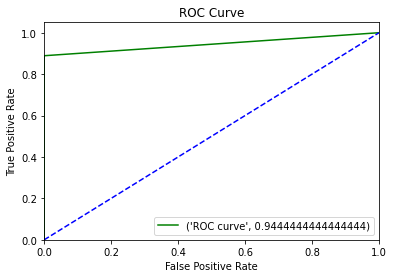

In [357]:
plt.plot(fpr, tpr, color='green', label = ('ROC curve', area_train_uc))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

In [358]:
stat_model = sm.Logit(Y_train,new_X_train)
stat_fit = stat_model.fit(maxiter=10)
print(stat_fit.summary())

         Current function value: 0.000375
         Iterations: 10
                           Logit Regression Results                           
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Jun 2021   Pseudo R-squ.:                  0.9990
Time:                        03:47:17   Log-Likelihood:              -0.025847
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.519e-11
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
third quartile1    -2.8269      4.066     -0.695      0.487     -10.795       5.141
min5                4.2736      9.695      0.441  

Summary was unable to be generated, fitting without max iteration being provided, as there was perfect sepration

### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.


In [359]:
# Creating new test set containing features of our best (l,p) found in diii)
new_X_test = X_test[X_test.columns[fit_rfecv.support_]]
new_X_test

third quartile1   min5   max5  third quartile5
0           42.0000  27.25  38.25          36.0000
1           43.6700  27.67  38.50          34.5000
2           26.5000  10.67  30.00          27.0000
3           30.0000   0.00  33.00          20.7500
4           40.2500   7.00  25.50          21.7500
5           40.2500  10.50  24.33          21.5000
6           40.0625   7.50  24.25          21.0000
7           29.0000   0.00  21.00          10.7500
8           48.0000   0.00  12.75           5.5425
9           48.0000   0.00  12.00          10.0000
10          43.5000   1.00  28.00          17.6900
11          46.5000   2.00  24.00          21.0000
12          45.3300   4.75  26.75          21.0000
13          46.5000   0.00  23.00          17.7500
14          44.5000   2.00  21.25          16.5000
15          45.3725   1.33  21.33          18.5650
16          37.7500   6.75  26.00          18.6700
17          36.7500   7.25  25.00          18.7500
18          38.2500   7.00  24.50          18.5000

**Checking accuracy on the Testing data**

In [360]:
y_test_pred = logic_reg.predict(new_X_test)
acc_score_best = logic_reg.score(new_X_test,Y_test)
f1_score_best = f1_score(Y_test, y_test_pred)
print("Accuracy score for testing data comprising best features is:", acc_score_best)
print("F1 score for testing data comprising best features is:", f1_score_best)
con_matrix = confusion_matrix(Y_test, y_test_pred)
print("Confusion matrix for testing data comprising best features is:\n",con_matrix)
fpr, tpr, _ = roc_curve(Y_test, y_test_pred)
area_test_uc = auc(fpr, tpr)
print("AUC for testing data: ", area_test_uc)

Accuracy score for testing data comprising best features is: 1.0
F1 score for testing data comprising best features is: 1.0
Confusion matrix for testing data comprising best features is:
 [[15  0]
 [ 0  4]]
AUC for testing data:  1.0


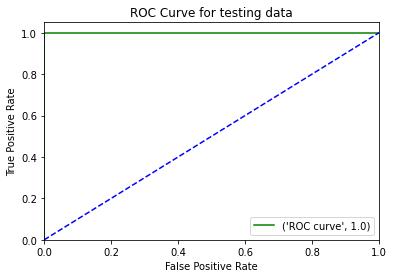

In [361]:
plt.figure()
plt.plot(fpr, tpr, color='green', label=('ROC curve', area_test_uc) )
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for testing data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()


CV accuracy obtained earlier and test accuracy is 1.0
Both of the model is performing well. But there is imbalance is dance. There is less bending compare to other activities

### vi.Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, Classes are  well separated to cause instablity. Without max iteration, as stated above I was getting error as there is perfect separation of data. Max iteration need to be set inorder to avoid instability.

### vii.  From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Yes from the confusion matrix it is clearly evident there is imbalanced data. From training data confusion matrix we can see there is ration of bending and other activities is 60:9 , while in testing data confusion matrix ratio is 15:4

Upsampling of training data will be done to solve the problem of imbalance in the dataset

In [362]:
#warnings.filterwarnings('ignore')
final_f1 = np.array([])
final_accuracy = np.array([])
i_val =  np.array([])

# Break time series in various len
for i in range( 1, 21):
    split_df =  break_df(i)
    i_val = np.append(i_val, i)
 
    # Splitting the whole dataset to training and testing data
    split_train, split_test = split_data(split_df)
    split_train = adding_activity_train(split_train)
    
    #Upscaling
    # From training data getting data points where bending is 1
    bend_df = split_train.loc[split_train['bending'] == 1]
    
    # From training data getting data points where other activities are done 
    non_bend_df = split_train.loc[split_train['bending'] == 0]
   
    
    # Upsampling the bending class
    up_bend_df =  resample(bend_df, n_samples = 60, replace=True)
    train_bend = pd.concat([non_bend_df, up_bend_df])
    train_bend.reset_index( drop =  True, inplace = True) 
       
    # Splitting upscaled training data to predictor and response
    X_train , Y_train = split_input_output(train_bend)
    logic_reg = LogisticRegression( C=10000 ,max_iter= 10, n_jobs =-1 )
    st_kcv = StratifiedKFold(n_splits = 5, shuffle = False)
    f1_scores = np.array([])
    accuracy = np.array([])
    feature_lst = []
    
    # Generate indices to split data into training and test set.
    for train_index, test_index in st_kcv.split(X_train , Y_train):
        rfecv = RFECV(estimator = logic_reg, step=1, cv = StratifiedKFold(n_splits = 5, shuffle = False), scoring = 'accuracy')
        fit_rfecv = rfecv.fit(X_train.loc[train_index], Y_train[train_index])
        
        # Selecting best features 
        selected_feat_lst = X_train.columns[fit_rfecv.support_]
        X = X_train.loc[train_index][selected_feat_lst]
        X_valid = X_train.loc[test_index][selected_feat_lst]
       
        # Fitting again with the best features
        fit_agn = logic_reg.fit(X, Y_train[train_index])
        y_pred = logic_reg.predict(X_valid)
        accuracy = np.append(accuracy, logic_reg.score(X_valid, Y_train[test_index]))
        f1_scores = np.append(f1_scores,f1_score(Y_train[test_index], y_pred, average = 'weighted'))
   
    final_f1 = np.append(final_f1, np.mean(f1_scores))
    final_accuracy = np.append(final_accuracy, np.mean(accuracy))



In [363]:
# Creating pd for upscaled dataset, to find best l 
res_up_df = pd.DataFrame(np.column_stack([i_val, final_accuracy, final_f1]),\
                              columns=[ 'l','Accuracy',  'F1 score', ])
res_up_df

l  Accuracy  F1 score
0    1.0  0.966667  0.966255
1    2.0  0.975000  0.974957
2    3.0  0.991667  0.991652
3    4.0  0.983333  0.983217
4    5.0  0.991667  0.991652
5    6.0  0.991667  0.991652
6    7.0  0.991667  0.991652
7    8.0  0.991667  0.991652
8    9.0  0.991667  0.991652
9   10.0  0.991667  0.991652
10  11.0  0.991667  0.991652
11  12.0  0.991667  0.991652
12  13.0  1.000000  1.000000
13  14.0  1.000000  1.000000
14  15.0  0.991667  0.991652
15  16.0  0.991667  0.991652
16  17.0  0.991667  0.991652
17  18.0  0.991667  0.991652
18  19.0  1.000000  1.000000
19  20.0  0.983333  0.983217

In [364]:
# Getting index of best f1 score
up_ind = np.argmax(res_up_df['F1 score'])
best_up_l = (res_up_df['l'][up_ind]).astype(int)
print("The value of best l is: ", best_up_l, " Having best f1 score: ",res_up_df['F1 score'][up_ind], " and \
accuracy is:", res_up_df['Accuracy'][up_ind])

The value of best l is:  13  Having best f1 score:  1.0  and accuracy is: 1.0


In [365]:
# Using best l
split_df =  break_df(best_up_l)

# Splitting the whole dataset to training and testing data
split_train, split_test = split_data(split_df)
split_train = adding_activity_train(split_train)

#Upscaling
# From training data getting data points where bending is 1
bend_df = split_train.loc[split_train['bending'] == 1]

# From training data getting data points where other activities are done 
non_bend_df = split_train.loc[split_train['bending'] == 0]


# Upsampling the bending class for training data
up_bend_df =  resample(bend_df, n_samples = 60, replace=True)
train_up_bend = pd.concat([non_bend_df, up_bend_df])
train_up_bend.reset_index( drop =  True, inplace = True) 

# Spliting train data into predictor and response
X_up_train , Y_up_train = split_input_output(train_up_bend)

# Spliting test data into predictor and response
split_test = adding_activity_test(split_test)
X_test , Y_test = split_input_output(split_test)

# Fit the model with the same (l,p) found in d iii)
logic_reg = LogisticRegression( C=10000 ,max_iter= 10, n_jobs =-1 )

rfecv = RFECV(estimator = logic_reg, step=1, cv = StratifiedKFold(n_splits = 5, shuffle = False), scoring = 'accuracy')
fit_up_rfecv = rfecv.fit(X_up_train,Y_up_train)
best_features = X_up_train.columns[fit_up_rfecv.support_]
new_X_up_train = X_up_train[best_features]
print( " Best l and p is for upscaled dataset ", best_up_l, fit_up_rfecv.n_features_)
print(" The best features are", best_features)



 Best l and p is for upscaled dataset  13 3
 The best features are Index(['min11', 'max49', 'min71'], dtype='object')


**Checking accuracy on the Training Data**

In [366]:
# Fitting the upsampled data set
logic_reg = LogisticRegression( C=10000 , max_iter = 10, n_jobs =-1 )
# rfecv = RFECV(estimator = logic_reg, step=1, cv = StratifiedKFold(n_splits = 5, shuffle = False), scoring = 'accuracy')
# fit_rfecv = rfecv.fit(X_train, Y_train)
logic_reg = logic_reg.fit(new_X_up_train, Y_up_train)
Y_up_train_pred = logic_reg.predict(new_X_up_train)
cm_up = confusion_matrix(Y_up_train, Y_up_train_pred)

acc_up_score_best = logic_reg.score(new_X_up_train,Y_up_train)
f1_up_score_best = f1_score(Y_up_train, Y_up_train_pred)
print("Accuracy for best l for the upscaled training data is:", acc_up_score_best)
print("F1 score for best l for the upscaled training data is:", f1_up_score_best)
print("Confusion matrix for best l for the upscaled training data is: \n",cm_up)
fpr, tpr, _= roc_curve(Y_up_train, Y_up_train_pred)
area_train_up = auc(fpr, tpr)
print("Area under the curve", area_train_up)

Accuracy for best l for the upscaled training data is: 1.0
F1 score for best l for the upscaled training data is: 1.0
Confusion matrix for best l for the upscaled training data is: 
 [[60  0]
 [ 0 60]]
Area under the curve 1.0


From the confusion matrix it it evident class is balanced 

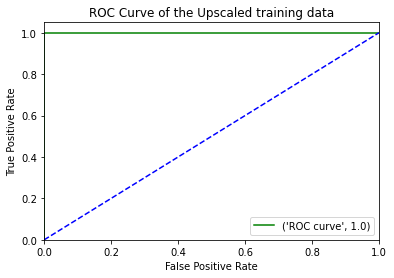

In [367]:
plt.plot(fpr, tpr, color='green', label = ('ROC curve', area_train_up))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the Upscaled training data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

**Checking accuracy on the Training Data**

Note upscaling was done only for training set. Testing data set is not upscaled to represent true values and test accuracy

In [368]:
# Creating new X test conatining  best features
new_X_test = X_test[best_features]

# Testing accuracy of upscaled model
y_up_test_pred = logic_reg.predict(new_X_test)
acc_score_best = logic_reg.score(new_X_test,Y_test)
f1_score_best = f1_score(Y_test, y_up_test_pred)
print("Accuracy score for testing data comprising best features is:", acc_score_best)
print("F1 score for testing data comprising best features is:", f1_score_best)
con_matrix_test = confusion_matrix(Y_test, y_up_test_pred)
print("Confusion matrix for testing data comprising best features is:\n",con_matrix_test)
fpr, tpr, _ = roc_curve(Y_test, y_up_test_pred)
area_test_up = auc(fpr, tpr)
print("AUC for testing data: ", area_test_up)

Accuracy score for testing data comprising best features is: 1.0
F1 score for testing data comprising best features is: 1.0
Confusion matrix for testing data comprising best features is:
 [[15  0]
 [ 0  4]]
AUC for testing data:  1.0


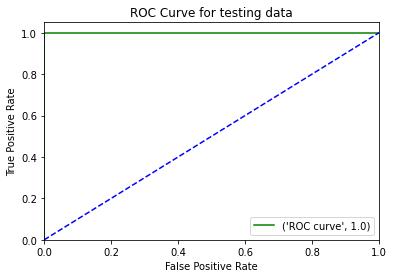

In [369]:
plt.figure()
plt.plot(fpr, tpr, color='green', label=('ROC curve', area_test_up) )
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for testing data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()


Accuracy and F1 score of Upscaled model is 1
Also accuracy and F1 score of the model without any case control is 1. Both 
the model performance is same

## e) Binary Classification Using L 1 -penalized logistic regression  

### i. Repeat 1(d)iii using L 1 -penalized logistic regression, i.e. instead of using p- values for variable selection, use L 1 regularization. Note that in this problem, you have to cross-validate for both l , the number of time series into which you break each of your instances, and λ , the weight of L 1 penalty in your logistic regression objective function (or C , the budget). Packages usually perform cross-validation for λ automatically. 9

Here we will do cross validation to get both l and C(budget)

In [370]:
warnings.filterwarnings('ignore')
i_val =  np.array([])
all_c =  np.array([])
best_cv =  np.array([])

print(" All C:\n")
# Break time series in various len
for i in range( 1,21):
    split_df =  break_df(i)
    i_val = np.append(i_val, i)
 
    # Splitting the whole dataset to training and testing data
    split_train, split_test = split_data(split_df)
    split_train = adding_activity_train(split_train)
    X_train , Y_train = split_input_output(split_train)
    
    # Standardizing features
    val_x = X_train.values
    xy_scaler = MinMaxScaler()
    xy_scaled = xy_scaler.fit_transform(val_x)
    l1_X_train = pd.DataFrame(xy_scaled)
    l1_X_train.columns = X_train.columns
   
    # Fitting of model
    logic_cv = LogisticRegressionCV( Cs = np.logspace(-1, 1, 100), penalty='l1',\
                                    solver='liblinear', cv = StratifiedKFold(n_splits = 5, shuffle = False),\
                                    n_jobs =-1, class_weight= 'balanced', scoring = 'accuracy') 
    logic_cv.fit(l1_X_train , Y_train)
    print( logic_cv.Cs_ )
    
    # C_ : Array of C that maps to the best scores across every class. 
    # Cs_: Array of C i.e. inverse of regularization parameter values used for cross-validation.
    all_c = np.append(all_c, logic_cv.C_[0])
    index_c = np.where(logic_cv.Cs_ == logic_cv.C_[0])[0][0]
    best_cv = np.append(best_cv, np.mean(list(zip(*logic_cv.scores_[1]))[index_c]))
    
 


 All C:

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124   4.328

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124   4.32876128  4.

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124   4.32876128  4.

In [371]:
# Creating pd  to find best l 
l1_df = pd.DataFrame(np.column_stack([i_val, all_c, best_cv]),\
                              columns=[ 'l','C',  'CV score', ])
l1_df

l          C  CV score
0    1.0   2.595024  0.928571
1    2.0   0.705480  0.914286
2    3.0   0.705480  0.985714
3    4.0   0.977010  0.971429
4    5.0   2.364489  0.957143
5    6.0   1.629751  0.957143
6    7.0   2.056512  0.971429
7    8.0   1.072267  0.941758
8    9.0   0.890215  0.942857
9   10.0   0.613591  0.928571
10  11.0   0.932603  0.898901
11  12.0   1.629751  0.927473
12  13.0  10.000000  0.914286
13  14.0   0.977010  0.914286
14  15.0   1.232847  0.884615
15  16.0   0.559081  0.900000
16  17.0   3.430469  0.927473
17  18.0   1.232847  0.942857
18  19.0   1.291550  0.942857
19  20.0   0.977010  0.928571

In [372]:
# Getting index of best cv score
cv_ind = np.argmax(l1_df['CV score'])
best_c = l1_df['C'][cv_ind]
best_l = (l1_df['l'][cv_ind]).astype(int)
print("The best pair (l,C)  is: (",best_l, best_c, ")")

The best pair (l,C)  is: ( 3 0.7054802310718644 )


### ii. Compare the L 1 -penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Using best l and C 

In [373]:
split_df =  break_df(best_l)

# Splitting the whole dataset to training and testing data
split_train, split_test = split_data(split_df)
split_train = adding_activity_train(split_train)
l1_X_train , l1_Y_train = split_input_output(split_train)

# Standardizing features
val_x = l1_X_train.values
min_max = MinMaxScaler()
min_maxed = min_max.fit_transform(val_x)
new_l1_X_train = pd.DataFrame(min_maxed)
new_l1_X_train.columns = l1_X_train.columns

# Fitting of model
logic_cv = LogisticRegression( C = best_c, penalty='l1',\
                                solver='liblinear',  n_jobs =-1, class_weight= 'balanced') 
logic_cv = logic_cv.fit(new_l1_X_train , l1_Y_train)


**Checking accuracy on the Training Data**

In [374]:
# Get Accuracy, f1 score, Cm, RoC, AUC
acc_l1 = logic_cv.score(new_l1_X_train , l1_Y_train)

# training accuracy of upscaled model
y_l1_train_pred = logic_cv.predict(new_l1_X_train)
f1_score_l1 = f1_score(l1_Y_train, y_l1_train_pred)
print("Accuracy score for training data with L1 regulaztion:", acc_l1)
print("F1 score for training data with L1 regulaztionis:", f1_score_l1)
cm_l1_train = confusion_matrix(l1_Y_train, y_l1_train_pred)
print("Confusion matrix for training datawith L1 regulaztion is:\n",cm_l1_train)
fpr, tpr, _ = roc_curve(l1_Y_train, y_l1_train_pred)
area_l1_train = auc(fpr, tpr)
print("AUC for training data: ", area_l1_train)

Accuracy score for training data with L1 regulaztion: 0.9710144927536232
F1 score for training data with L1 regulaztionis: 0.9
Confusion matrix for training datawith L1 regulaztion is:
 [[58  2]
 [ 0  9]]
AUC for training data:  0.9833333333333334


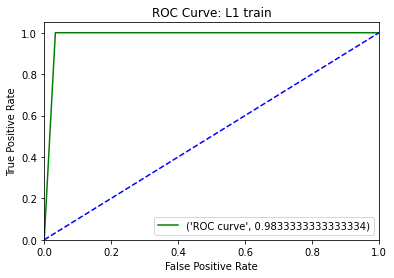

In [375]:
plt.figure()
plt.plot(fpr, tpr, color='green', label=('ROC curve', area_l1_train) )
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: L1 train')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

**Checking accuracy on the Testing Data**

In [376]:
# Get test set
split_test = adding_activity_train(split_test)
l1_X_test , l1_Y_test = split_input_output(split_test)

# Standardizing features
val_x = l1_X_test.values
min_max = MinMaxScaler()
min_maxed = min_max.fit_transform(val_x)
new_l1_X_test = pd.DataFrame(min_maxed)
new_l1_X_test.columns = l1_X_test.columns


In [377]:
# Get Accuracy, f1 score, Cm, RoC, AUC
acc_l1 = logic_cv.score(new_l1_X_test , l1_Y_test)

# Testing accuracy of upscaled model
y_l1_test_pred = logic_cv.predict(new_l1_X_test)
f1_score_l1 = f1_score(l1_Y_test, y_l1_test_pred)
print("Accuracy score for L1-penalized logistic regression model on the testing is:", acc_l1)
print("F1 score for L1-penalized logistic regression model on the testing is:", f1_score_l1)
cm_l1_test = confusion_matrix(l1_Y_test, y_l1_test_pred)
print("Confusion matrix of the testing data for L1-penalized logistic regression model is:\n",cm_l1_test)
fpr, tpr, _ = roc_curve(l1_Y_test, y_l1_test_pred)
area_l1 = auc(fpr, tpr)
print("AUC for testing data: ", area_l1)

Accuracy score for L1-penalized logistic regression model on the testing is: 0.9473684210526315
F1 score for L1-penalized logistic regression model on the testing is: 0.888888888888889
Confusion matrix of the testing data for L1-penalized logistic regression model is:
 [[14  1]
 [ 0  4]]
AUC for testing data:  0.9666666666666667


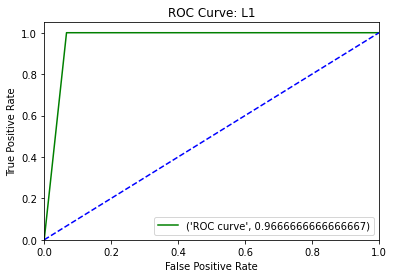

In [378]:
plt.figure()
plt.plot(fpr, tpr, color='green', label=('ROC curve', area_l1) )
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: L1')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()


In [379]:
print("Classification report of L1 penalized on testing data\n",classification_report(l1_Y_test,y_l1_test_pred))

Classification report of L1 penalized on testing data
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.80      1.00      0.89         4

    accuracy                           0.95        19
   macro avg       0.90      0.97      0.93        19
weighted avg       0.96      0.95      0.95        19



**L1 penalized vs Variable selection with p- values**( I used backward selection using sklearn.feature
selection)

| Category | L1 penalized LR (test)| Variable selection with RFECV(test) |
| ---  | --- | --- |
| AUC | 0.966 |1 |
| ---  | --- | --- 
| Accuracy | 0.947| 1 |
| ---  | --- | --- | 
| F1 score | 0.88 | 1 |
| ---  | --- | --- |



Best l was 1 for Variable selection with RFECV while l is 3 for L1 penalized model.
Accuracy of L1 penalized model on the training data is  0.97 an f1 score 0.9
Accuracy of Variable selection with RFECV model on the training data is  0.98 an f1 score 0.94
From the above tablec on testing data we can say Variable selection with RFECV performed better than L1 penalized model

In terms of implementation, The L1 penalized  is easier to implement as compare to Variable selection with RFECV. Also computation is faster for L1 penalized as compare to Variable selection with RFECV. Backward selection with lot of features takes more time to give result. Also with backward selection we had to use max iteration which was not necessary for L1 penalized model.

## f) Multi-class Classification (The Realistic Case)

###  i. Find the best l in the same way as you found it in 1(e)i to build an L 1 - penalized multinomial regression model to classify all activities in your train- ing set.  Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible. 

**L 1 - penalized multinomial regression**

Note: Bending 1 and bending 2 are considered as the same activity: bending

In [380]:

i_val =  np.array([])
all_c_multi =  np.array([])
best_cv_multi =  np.array([])
activity_name =['bending1', 'bending2', 'cycling','lying','sitting','standing','walking']
print(" All C for multinomial :\n")
# Break time series in various len
for i in range( 1,21):
    split_df =  break_df(i)
    i_val = np.append(i_val, i)
 
    # Splitting the whole dataset to training and testing data
    split_train, split_test = split_data(split_df)
    #split_train = adding_activity_train(split_train)
    X_train , Y_train = split_input_output(split_train, activity_name= 'activity')
    Y_train = Y_train.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})

    # Standardizing features
    val_x = X_train.values
    xy_scaler = MinMaxScaler()
    xy_scaled = xy_scaler.fit_transform(val_x)
    l1_X_train = pd.DataFrame(xy_scaled)
    l1_X_train.columns = X_train.columns
   
    # Fitting of model
    # 'liblinear' is limited to one-versus-rest schemes.
    # also multinomial is unavailable when solver= 'liblinear'.
    logic_cv = LogisticRegressionCV( Cs = np.logspace(-1, 1, 100), penalty='l1',\
                                    solver='saga', multi_class='multinomial',cv = StratifiedKFold(n_splits = 5, shuffle = False),\
                                    n_jobs =-1, class_weight= 'balanced', scoring = 'accuracy') 
    logic_cv.fit(l1_X_train , Y_train)
    print( logic_cv.Cs_ )
    print("For l", i, "\n",logic_cv.C_[0])
    
    # C_ : Array of C that maps to the best scores across every class. 
    # Cs_: Array of C i.e. inverse of regularization parameter values used for cross-validation.
    all_c_multi = np.append(all_c_multi, logic_cv.C_[0])
    index_c = np.where(logic_cv.Cs_ == logic_cv.C_[0])[0][0]
    for act in range(0,6):
        act_scores = np.mean(list(zip(*logic_cv.scores_[act]))[index_c])
    best_cv_multi = np.append(best_cv_multi, np.mean(act_scores))
    
 


 All C for multinomial :

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124   4.32876128  4.

[ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916  3.43046929  3.59381366
  3.76493581  3.94420606  4.1320124   4.32876128  4.

In [381]:
# Creating pd for L1 Multinomial to find best l 
multi_df = pd.DataFrame(np.column_stack([i_val, all_c_multi, best_cv_multi]),\
                              columns=[ 'l','C',  'CV score' ])
multi_df

l         C  CV score
0    1.0  3.593814  0.898901
1    2.0  1.629751  0.871429
2    3.0  1.232847  0.798901
3    4.0  1.291550  0.796703
4    5.0  1.291550  0.827473
5    6.0  1.417474  0.827473
6    7.0  2.056512  0.813187
7    8.0  4.132012  0.798901
8    9.0  1.023531  0.826374
9   10.0  1.291550  0.767033
10  11.0  2.056512  0.754945
11  12.0  0.932603  0.752747
12  13.0  0.932603  0.783516
13  14.0  0.932603  0.697802
14  15.0  0.890215  0.709890
15  16.0  0.977010  0.725275
16  17.0  0.977010  0.753846
17  18.0  0.977010  0.696703
18  19.0  1.963041  0.726374
19  20.0  2.257020  0.727473

In [382]:
# Getting index of best cv score
cv_ind = np.argmax(multi_df['CV score'])
best_c_multi = multi_df['C'][cv_ind]
best_l_multi = (multi_df['l'][cv_ind]).astype(int)
print("The best pair (l,C)  is: (",best_l_multi, best_c_multi, ")")

The best pair (l,C)  is: ( 1 3.5938136638046276 )


Using best l and C 

In [383]:
split_df =  break_df(best_l_multi)

# Splitting the whole dataset to training and testing data
multi_split_train, multi_split_test = split_data(split_df)
l1_X_train , multi_Y_train = split_input_output(multi_split_train, activity_name= 'activity')

# Standardizing features
val_x = l1_X_train.values
min_max = MinMaxScaler()
min_maxed = min_max.fit_transform(val_x)
multi_X_train = pd.DataFrame(min_maxed)

# Getting columns name same as before normalizing
multi_X_train.columns = l1_X_train.columns
multi_Y_train = multi_Y_train.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})

# Fitting of model
logic_cv = LogisticRegression( C = best_c_multi, penalty='l1',\
                                solver='saga',  n_jobs =-1, multi_class='multinomial') 
logic_cv = logic_cv.fit(multi_X_train , multi_Y_train)


**Checking accuracy on the Training data**

In [384]:
# Getting Accuracy and  Cm of training data
acc_multi = logic_cv.score(multi_X_train , multi_Y_train)
multi_error = 1 -acc_multi
# training accuracy of upscaled model
y_multi_train_pred = logic_cv.predict(multi_X_train)
print("Accuracy score for training data for L1- penalized multinomial regression model is:", acc_multi)
print("Error for training data for L1- penalized multinomial regression model is:", multi_error)
cm_multi_train = confusion_matrix(multi_Y_train, y_multi_train_pred)
print("Confusion matrix of training data for L1- penalized multinomial regression model is:\n",cm_multi_train)


Accuracy score for training data for L1- penalized multinomial regression model is: 0.9565217391304348
Error for training data for L1- penalized multinomial regression model is: 0.04347826086956519
Confusion matrix of training data for L1- penalized multinomial regression model is:
 [[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  3  9  0]
 [ 0  0  0  0  0 12]]


**Checking accuracy on the Testing Data**

In [385]:
# Get test set
multi_X_test , multi_Y_test = split_input_output(multi_split_test, 'activity')

# Standardizing features
val_x = multi_X_test.values
min_max = MinMaxScaler()
min_maxed = min_max.fit_transform(val_x)
new_multi_X_test = pd.DataFrame(min_maxed)

# Getting columns name same as before normalizing
new_multi_X_test.columns = multi_X_test.columns#multi_X_test.loc[:,selected_feat_lst]

multi_Y_test = multi_Y_test.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})
    

In [386]:
# Get Accuracy and  Cm
acc_multi_test = logic_cv.score(new_multi_X_test , multi_Y_test)
test_error_multi = 1 - acc_multi_test
y_multi_test_pred = logic_cv.predict(new_multi_X_test)
print("Accuracy score for testing data for L1- penalized multinomial regression is:", acc_multi_test)
print("Test error for testing data for L1- penalized multinomial regression is:", test_error_multi)
cm_multi_test = confusion_matrix(multi_Y_test, y_multi_test_pred)
print("Confusion matrix of testing datafor L1- penalized multinomial regression is:\n",cm_multi_test)


Accuracy score for testing data for L1- penalized multinomial regression is: 0.8947368421052632
Test error for testing data for L1- penalized multinomial regression is: 0.10526315789473684
Confusion matrix of testing datafor L1- penalized multinomial regression is:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]


From the above confusion matrix, it can be observed that 2 classes are missclassified while the rest(the one in diagonal ) are classified correctly

In [387]:
# Function to generatr ROC curve for multi class using one vs rest approach
def generateROC(model_obj, X_train, Y_train, X_test, Y_test):

    # Binarizing the class
    y = label_binarize(Y_test, classes=[0,1,2,3,4,5])
    n_classes = y.shape[1]

    # Predict each class against the other
    onevsrest = OneVsRestClassifier(model_obj)
    y_score = onevsrest.fit(X_train, Y_train).predict_proba(X_test)
           
    # Creating empty dict to store fpr and tpr
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Finding  ROC curve and ROC area for each class in the multiclass
    for i in range(n_classes):
        fpr[i], tpr[i], p= roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Finding  micro-avg ROC curve and ROC area 
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='cornflowerblue', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['purple', 'orange', 'black','red','blue','aqua'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

    # Plot of a ROC curve for a specific class
    plt.plot([0, 1], [0, 1],linestyle='--',color='yellow')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for multiclass')
    plt.legend(loc="lower right")
    plt.show()

Computing roc auc score using one vs rest approach

In [388]:
# Ovr: Stands for One-vs-rest.
roc_auc_score(multi_Y_test, logic_cv.predict_proba(new_multi_X_test), multi_class='ovr')

0.9930555555555555

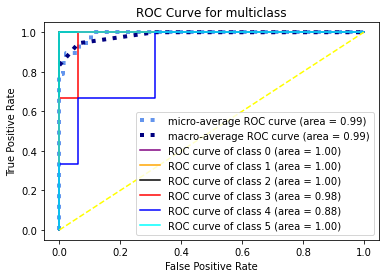

In [389]:
generateROC(logic_cv, multi_X_train, multi_Y_train, new_multi_X_test, multi_Y_test)

In [390]:
print(" Classification report of testinda data:\n",classification_report(multi_Y_test, y_multi_test_pred,target_names=['bending', 'cycling','lying','sitting','standing','walking']))

 Classification report of testinda data:
               precision    recall  f1-score   support

     bending       1.00      1.00      1.00         4
     cycling       1.00      1.00      1.00         3
       lying       0.75      1.00      0.86         3
     sitting       1.00      0.67      0.80         3
    standing       0.67      0.67      0.67         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.89        19
   macro avg       0.90      0.89      0.89        19
weighted avg       0.91      0.89      0.89        19



### ii. Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results. 

**Gaussian Naive Bayer's**

In [391]:
i_val =  np.array([])
all_score =  np.array([])
acc_score = np.array([])
# Break time series in various len
for i in range( 1,21):
    split_df =  break_df(i)
    i_val = np.append(i_val, i)
 
    # Splitting the whole dataset to training and testing data
    gaussplit_train, gaussplit_test = split_data(split_df)
    gaus_X_train , gaus_Y_train = split_input_output(gaussplit_train, activity_name= 'activity')
    gaus_Y_train = gaus_Y_train.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})
 
    # Fitting the model using GausianNb
    gaus_nb = GaussianNB()
    gaus_nb.fit(gaus_X_train , gaus_Y_train)
    cross_scores = cross_val_score(gaus_nb ,gaus_X_train ,gaus_Y_train,n_jobs =-1, cv=StratifiedKFold(5))
    all_score = np.append(all_score, np.mean(cross_scores))
 


In [392]:
# Creating pd for Gausian NB  to find best l 
gaus_df = pd.DataFrame(np.column_stack([i_val,  all_score]),\
                              columns=[ 'l',  'Gaus CV score' ])
gaus_df

l  Gaus CV score
0    1.0       0.813187
1    2.0       0.841758
2    3.0       0.753846
3    4.0       0.782418
4    5.0       0.680220
5    6.0       0.697802
6    7.0       0.754945
7    8.0       0.740659
8    9.0       0.695604
9   10.0       0.681319
10  11.0       0.667033
11  12.0       0.580220
12  13.0       0.667033
13  14.0       0.594505
14  15.0       0.565934
15  16.0       0.564835
16  17.0       0.593407
17  18.0       0.507692
18  19.0       0.564835
19  20.0       0.551648

In [393]:
# Getting index of best cv score
cv_ind = np.argmax(gaus_df['Gaus CV score'])
best_l_gaus = (gaus_df['l'][cv_ind]).astype(int)
print("The best l: (",best_l_gaus, ")")

The best l: ( 2 )


Using best l

In [394]:
split_df =  break_df(best_l_gaus)

# Splitting the whole dataset to training and testing data
gaus_split_train, gaus_split_test = split_data(split_df)
gaus_X_train  , gaus_Y_train = split_input_output(gaus_split_train,activity_name= 'activity')
gaus_Y_train = gaus_Y_train.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5}) 
                                    
# Fitting of model
gaus_nb = GaussianNB()
gaus_nb.fit(gaus_X_train , gaus_Y_train)


GaussianNB()

**Checking accuracy on the Training data**

In [395]:
# Get Accuracy, f1 score, Cm, RoC, AUC
acc_gaus = gaus_nb.score(gaus_X_train , gaus_Y_train)
gaus_error = 1 -acc_gaus
y_gaus_train_pred = gaus_nb.predict(gaus_X_train)
print("Accuracy score for training data with gaus Naive Bayes is:", acc_gaus)
print("Error for training data with gaus Naive Bayes  is:", gaus_error)
cm_gaus_train = confusion_matrix(gaus_Y_train, y_gaus_train_pred)
print("Confusion matrix for training data with gaus Naive Bayes  is:\n",cm_gaus_train)


Accuracy score for training data with gaus Naive Bayes is: 0.9855072463768116
Error for training data with gaus Naive Bayes  is: 0.01449275362318836
Confusion matrix for training data with gaus Naive Bayes  is:
 [[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


**Checking accuracy on the Testing Data**

In [396]:
# Get test set
gaus_X_test , gaus_Y_test = split_input_output(gaus_split_test, 'activity')
gaus_Y_test = gaus_Y_test.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})

In [397]:
# Get Accuracy, f1 score, Cm, RoC, AUC
acc_gaus_test = gaus_nb.score(gaus_X_test , gaus_Y_test)
test_error_gaus = 1 - acc_gaus_test
y_gaus_test_pred = gaus_nb.predict(gaus_X_test)
print("Accuracy score for testing data with Gaus Naive Bayer's:", acc_gaus_test)
print("Test error for testing data with Gaus Naive Bayer's is:", test_error_gaus)
cm_gaus_test = confusion_matrix(gaus_Y_test, y_gaus_test_pred)
print("Confusion matrix for testing data with Gaus Naive Bayer's is:\n",cm_gaus_test)


Accuracy score for testing data with Gaus Naive Bayer's: 1.0
Test error for testing data with Gaus Naive Bayer's is: 0.0
Confusion matrix for testing data with Gaus Naive Bayer's is:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


Computing roc auc score using one vs rest approach

In [398]:
# Ovr: Stands for One-vs-rest.
roc_auc_score(gaus_Y_test, gaus_nb.predict_proba(gaus_X_test), multi_class='ovr')

1.0

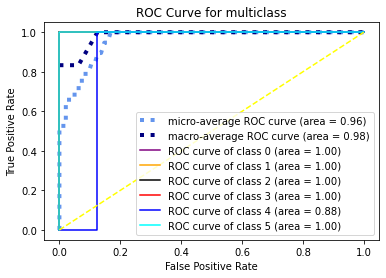

In [399]:
generateROC(gaus_nb, gaus_X_train, gaus_Y_train, gaus_X_test, gaus_Y_test)

In [400]:
print(" Classification report of testinda data:\n",classification_report(gaus_Y_test, y_gaus_test_pred,target_names=['bending', 'cycling','lying','sitting','standing','walking']))

 Classification report of testinda data:
               precision    recall  f1-score   support

     bending       1.00      1.00      1.00         4
     cycling       1.00      1.00      1.00         3
       lying       1.00      1.00      1.00         3
     sitting       1.00      1.00      1.00         3
    standing       1.00      1.00      1.00         3
     walking       1.00      1.00      1.00         3

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



**Multinomial Naive Bayes**

In [401]:
i_val =  np.array([])
all_multi_score =  np.array([])

# Break time series in various len
for i in range( 1,21):
    split_df =  break_df(i)
    i_val = np.append(i_val, i)
 
    # Splitting the whole dataset to training and testing data
    multigsplit_train, multigsplit_test = split_data(split_df)
    multig_X_train , multig_Y_train = split_input_output(multigsplit_train, activity_name= 'activity')
    multig_Y_train = multig_Y_train.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})
   
    # Fitting the model using multi- Nb
    multig_nb = MultinomialNB()
    multig_nb.fit(multig_X_train , multig_Y_train)
    cross_scores = cross_val_score(multig_nb ,multig_X_train ,multig_Y_train,n_jobs =-1, cv=StratifiedKFold(5))
    print(cross_scores)
    all_multi_score = np.append(all_multi_score, np.mean(cross_scores))
 


[0.85714286 0.71428571 0.92857143 0.71428571 0.76923077]
[0.78571429 0.78571429 0.71428571 0.78571429 0.69230769]
[0.71428571 0.92857143 0.64285714 0.64285714 0.69230769]
[0.78571429 0.78571429 0.71428571 0.64285714 0.76923077]
[0.78571429 0.85714286 0.85714286 0.78571429 0.76923077]
[0.78571429 0.92857143 0.92857143 0.57142857 0.76923077]
[0.78571429 0.85714286 0.85714286 0.5        0.76923077]
[0.78571429 0.92857143 0.85714286 0.57142857 0.76923077]
[0.78571429 0.92857143 0.78571429 0.57142857 0.76923077]
[0.78571429 0.92857143 0.85714286 0.64285714 0.76923077]
[0.78571429 0.85714286 0.85714286 0.5        0.76923077]
[0.78571429 0.92857143 0.85714286 0.57142857 0.76923077]
[0.78571429 0.85714286 0.85714286 0.57142857 0.76923077]
[0.78571429 0.85714286 0.78571429 0.64285714 0.76923077]
[0.78571429 0.92857143 0.78571429 0.64285714 0.76923077]
[0.78571429 0.92857143 0.78571429 0.57142857 0.76923077]
[0.78571429 0.92857143 0.78571429 0.57142857 0.76923077]
[0.78571429 0.85714286 0.785714

In [402]:
# Creating pd for multigian NB  to find best l 
multig_df = pd.DataFrame(np.column_stack([i_val,  all_multi_score]),\
                              columns=[ 'l',  'CV score' ])
multig_df

l  CV score
0    1.0  0.796703
1    2.0  0.752747
2    3.0  0.724176
3    4.0  0.739560
4    5.0  0.810989
5    6.0  0.796703
6    7.0  0.753846
7    8.0  0.782418
8    9.0  0.768132
9   10.0  0.796703
10  11.0  0.753846
11  12.0  0.782418
12  13.0  0.768132
13  14.0  0.768132
14  15.0  0.782418
15  16.0  0.768132
16  17.0  0.768132
17  18.0  0.739560
18  19.0  0.768132
19  20.0  0.768132

In [403]:
# Getting index of best cv score
cv_ind = np.argmax(multig_df['CV score'])
best_l_multig = (multig_df['l'][cv_ind]).astype(int)
print("The best l: (",best_l_multig, ")")

The best l: ( 5 )


Using best l

In [404]:
split_df =  break_df(best_l_multig)

# Splitting the whole dataset to training and testing data
multinb_split_train, multinb_split_test = split_data(split_df)
multinb_X_train  , multinb_Y_train = split_input_output(multinb_split_train,activity_name= 'activity')
multinb_Y_train = multinb_Y_train.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5}) 
                                    
# Fitting of model
multinb_nb = MultinomialNB()
multinb_nb = multinb_nb.fit(multinb_X_train , multinb_Y_train)


In [405]:
# Get Accuracy, f1 score, Cm, RoC, AUC
acc_multi = multinb_nb.score(multinb_X_train , multinb_Y_train)
multinb_error = 1 -acc_multi
y_multinb_train_pred = multinb_nb.predict(multinb_X_train)
print("Accuracy score for training data with multi Naive Bayes is:", acc_multi)
print("Error for training data with multi Naive Bayes  is:", multinb_error)
cm_multinb_train = confusion_matrix(multinb_Y_train, y_multinb_train_pred)
print("Confusion matrix for training data with multi Naive Bayes  is:\n",cm_multinb_train)


Accuracy score for training data with multi Naive Bayes is: 0.8985507246376812
Error for training data with multi Naive Bayes  is: 0.10144927536231885
Confusion matrix for training data with multi Naive Bayes  is:
 [[ 8  0  0  1  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0  9  0  3  0]
 [ 1  0  0 10  1  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


**Checking accuracy on the Testing Data**

In [406]:
# Get test set
multinb_X_test , multinb_Y_test = split_input_output(multinb_split_test, 'activity')
multinb_Y_test = multinb_Y_test.replace({'bending1': 0,'bending2': 0,'cycling': 1,'lying':2,'sitting':3,'standing':4,'walking':5})

In [407]:
# Get Accuracy, f1 score, Cm, RoC, AUC
acc_multinb_test = multinb_nb.score(multinb_X_test , multinb_Y_test)
test_error_multi = 1 - acc_multinb_test
y_multinb_test_pred = multinb_nb.predict(multinb_X_test)
print("Accuracy score for testing data with multinomial Naive Bayer's:", acc_multinb_test)
print("Test error for testing data with multinomial Naive Bayer's is:", test_error_multi)
cm_multinb_test = confusion_matrix(multinb_Y_test, y_multinb_test_pred)
print("Confusion matrix for testing data with multi Naive Bayer's is:\n",cm_multinb_test)


Accuracy score for testing data with multinomial Naive Bayer's: 0.8421052631578947
Test error for testing data with multinomial Naive Bayer's is: 0.1578947368421053
Confusion matrix for testing data with multi Naive Bayer's is:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 2 1 0]
 [0 0 0 0 0 3]]


Computing roc auc score using one vs rest approach

In [408]:
# Ovr: Stands for One-vs-rest.
roc_auc_score(multinb_Y_test, multinb_nb.predict_proba(multinb_X_test), multi_class='ovr')

0.9756944444444443

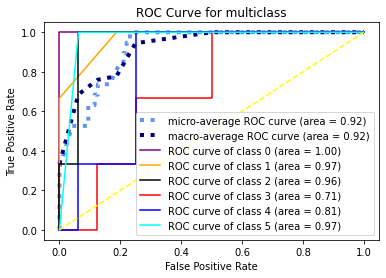

In [409]:
generateROC(multinb_nb, multinb_X_train, multinb_Y_train, multinb_X_test, multinb_Y_test)

In [412]:
print(" Classification report of test data of Multinomial Naive Bayes model is :\n",classification_report(multinb_Y_test, y_multinb_test_pred,target_names=['bending', 'cycling','lying','sitting','standing','walking']))

 Classification report of test data of Multinomial Naive Bayes model is :
               precision    recall  f1-score   support

     bending       1.00      1.00      1.00         4
     cycling       1.00      1.00      1.00         3
       lying       1.00      1.00      1.00         3
     sitting       0.50      0.67      0.57         3
    standing       0.50      0.33      0.40         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.84        19
   macro avg       0.83      0.83      0.83        19
weighted avg       0.84      0.84      0.84        19



Gaussian Naive Bayes model perform better than Multinomial Naive Bayes model

### iii. Which method is better for multi-class classification in this problem?

| Category | L1 Multinomial Penalized| Gaussian Naıve Bayes | Multinomial Naıve Bayes|
| ---  | --- | --- | --- |
|Accuracy(test)| 0.894 | 1 | 0.842 |
| ---  | --- | --- | --- |
|Test Error | 0.105 | 0 | 0.157 |


From the above data it is clearly evident Gaussian Naive Baye's model performed better compare to Mutinomial Naive Bayes and L1 Multionmial Bayes's model. Thus for this given dataset for multi class classification problem, Gaussian Naive Baye's model is the best among above all given model.

## ISLR

### ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 + β1X + β2X2 + β3X3 + 

Suppose that the true relationship between X and Y is linear,
i.e. Y = β0 + β1X + . Consider the training residual sum of
squares (RSS) for the linear regression, and also the training
RSS for the cubic regression.Would we expect one to be lower
than the other, would we expect them to be the same, or is there
not enough information to tell? Justify your answer

a) Generally lower value for the RSS is ideal in any model. The cubic curve will fit more to training data compare to linear line .Thus cubic regression will overfit to training data and have lower bias than linear regression model. Hence RSS of cubic regrsion on training data will be lower as compare to linear regression on the training data.

 Answer (a) using test rather than training RSS

b) There is more chance of RSS of linear regression on testing data lower than that of cubic regression on the training data.
Given , cubic regresion will overfit the mode and hence it wont't be able to generalize to new points(test data). The model on Linear Regression will genralize much better as compare to Cubic regression.

Suppose that the true relationship between X and Y is not linear,
but we don’t know how far it is from linear. Consider the training
RSS for the linear regression, and also the training RSS for the
cubic regression. Would we expect one to be lower than the
other, would we expect them to be the same, or is there not
enough information to tell? Justify your answer.

c) Cubic regression will have lower RSS on training data as compare to linear regression. Again  it is due to cubic curve flexibility and more no of predictors.


 Answer (c) using test rather than training RSS.

(d) There is not enough information. We need to know the true relation between X and Y. If true relation is closer to linear than cubic model, then RSS of linear regression model will be less for testing data as compare to cubic regression. Else RSS of cubic regression on testing data will be less.

### ISLR, 4.7.3

This problem relates to the QDA model, in which the observations
within each class are drawn from a normal distribution with a classspecific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.
Suppose that we have K classes, and that if an observation belongs
to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk, σ2
k). Recall that the density function for the
one-dimensional normal distribution is given in (4.11). Prove that in
this case, the Bayes’ classifier is not linear. Argue that it is in fact
quadratic.

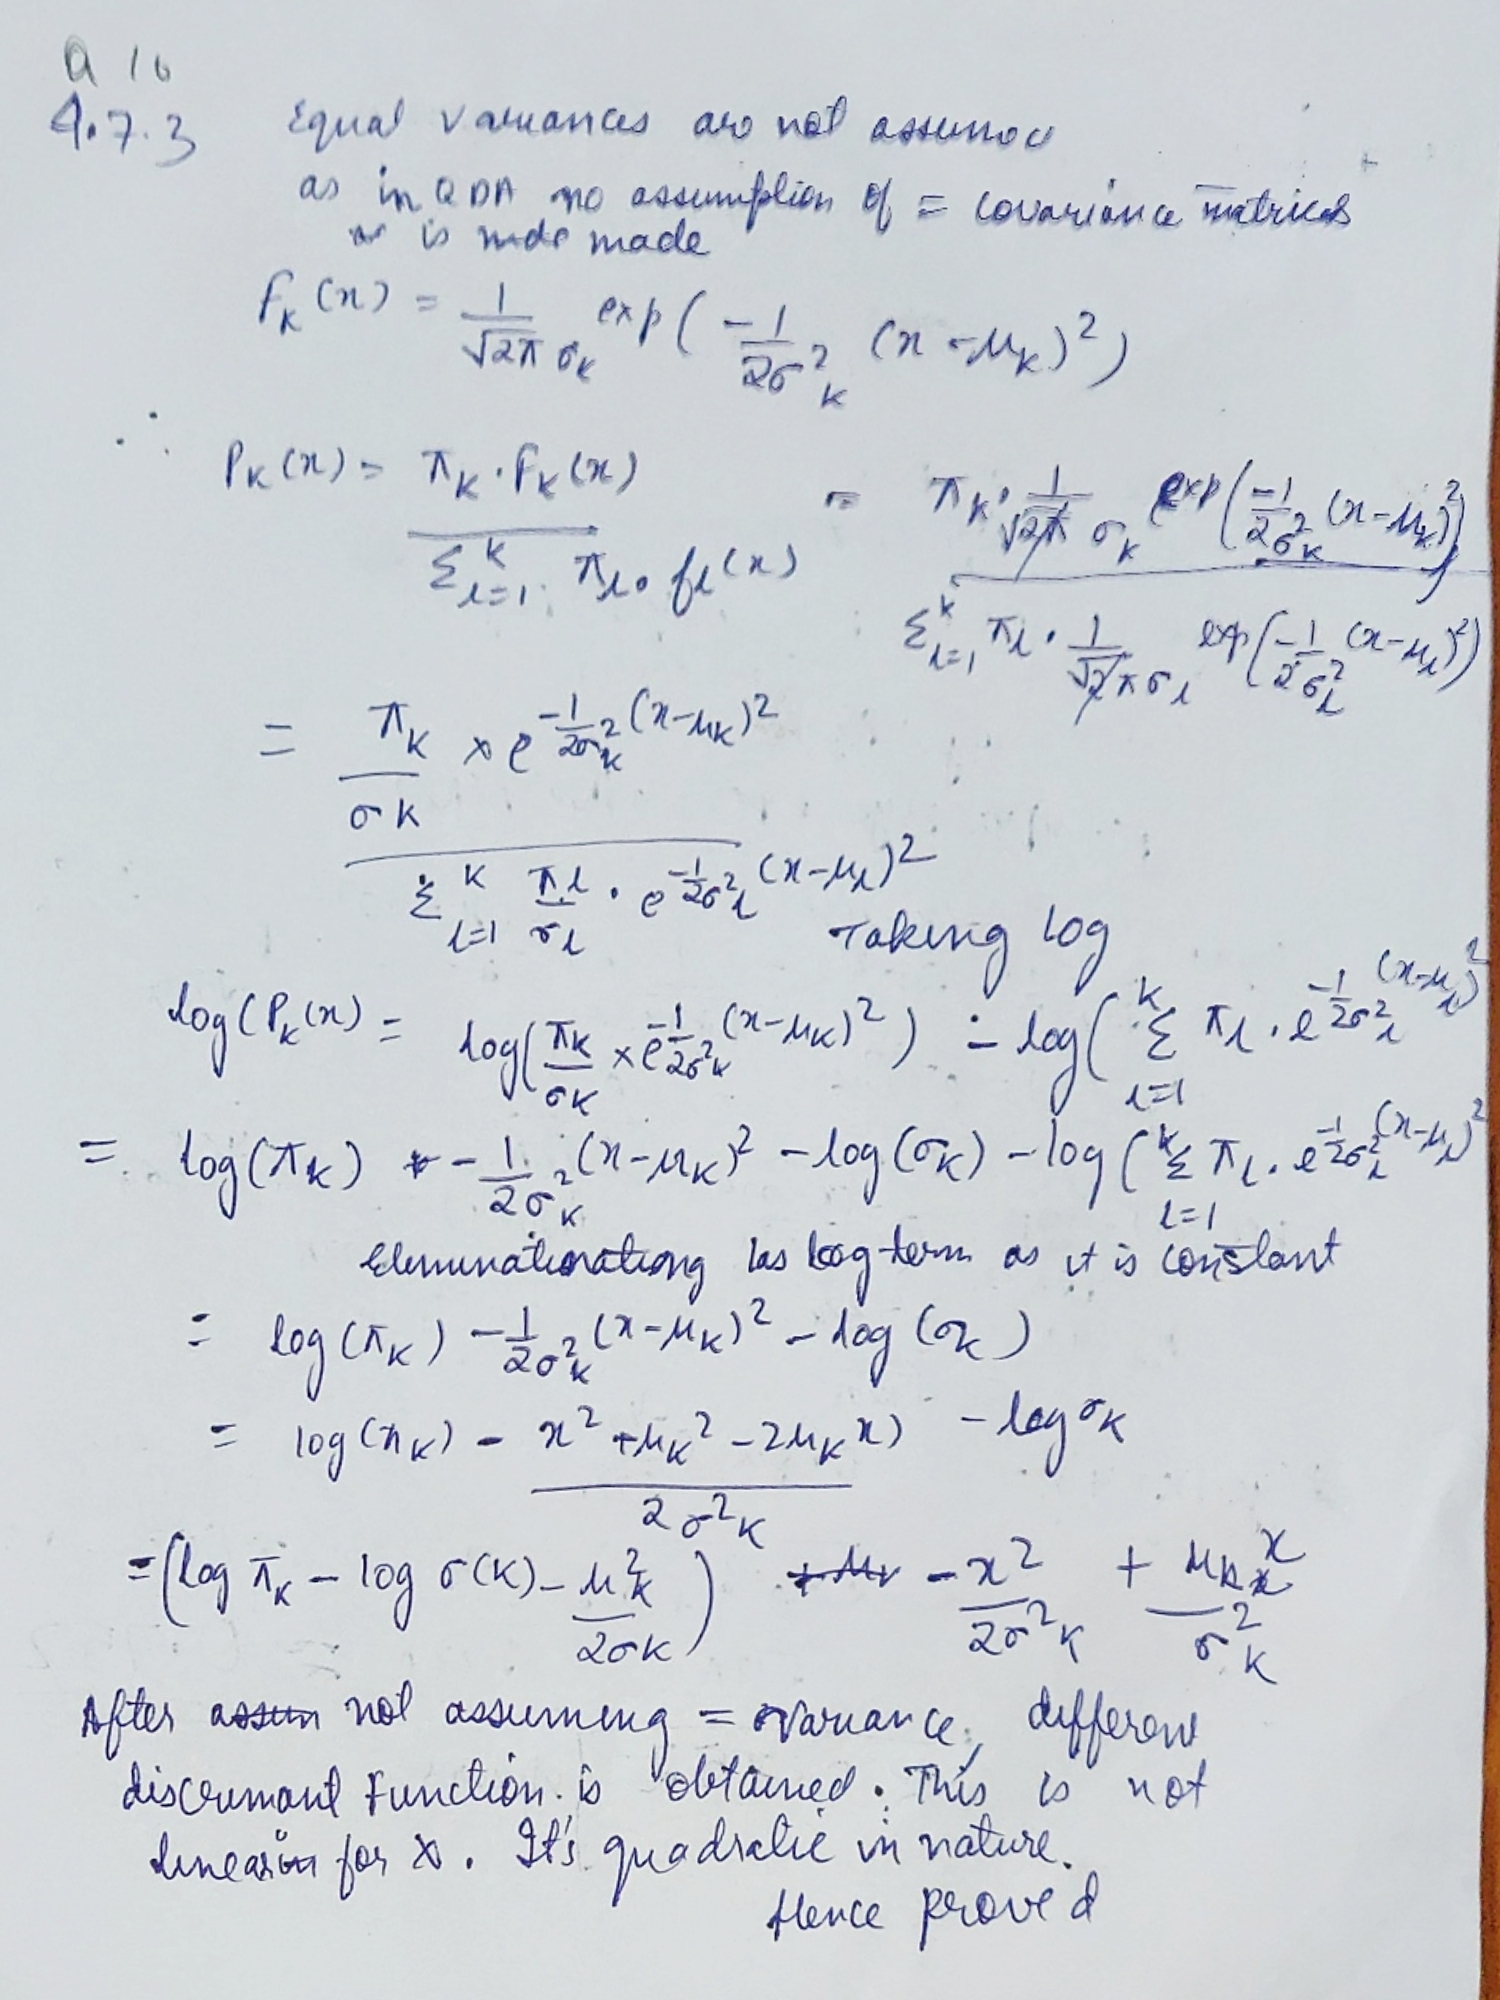

### ISLR 4.7.7

Suppose that we wish to predict whether a given stock will issue a
dividend this year (“Yes” or “No”) based on X, last year’s percent
profit. We examine a large number of companies and discover that the
mean value of X for companies that issued a dividend was X¯ = 10,
while the mean for those that didn’t was X¯ = 0. In addition, the
variance of X for these two sets of companies was ˆσ2 = 36. Finally,
80 % of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue
a dividend this year given that its percentage profit was X = 4 last
year

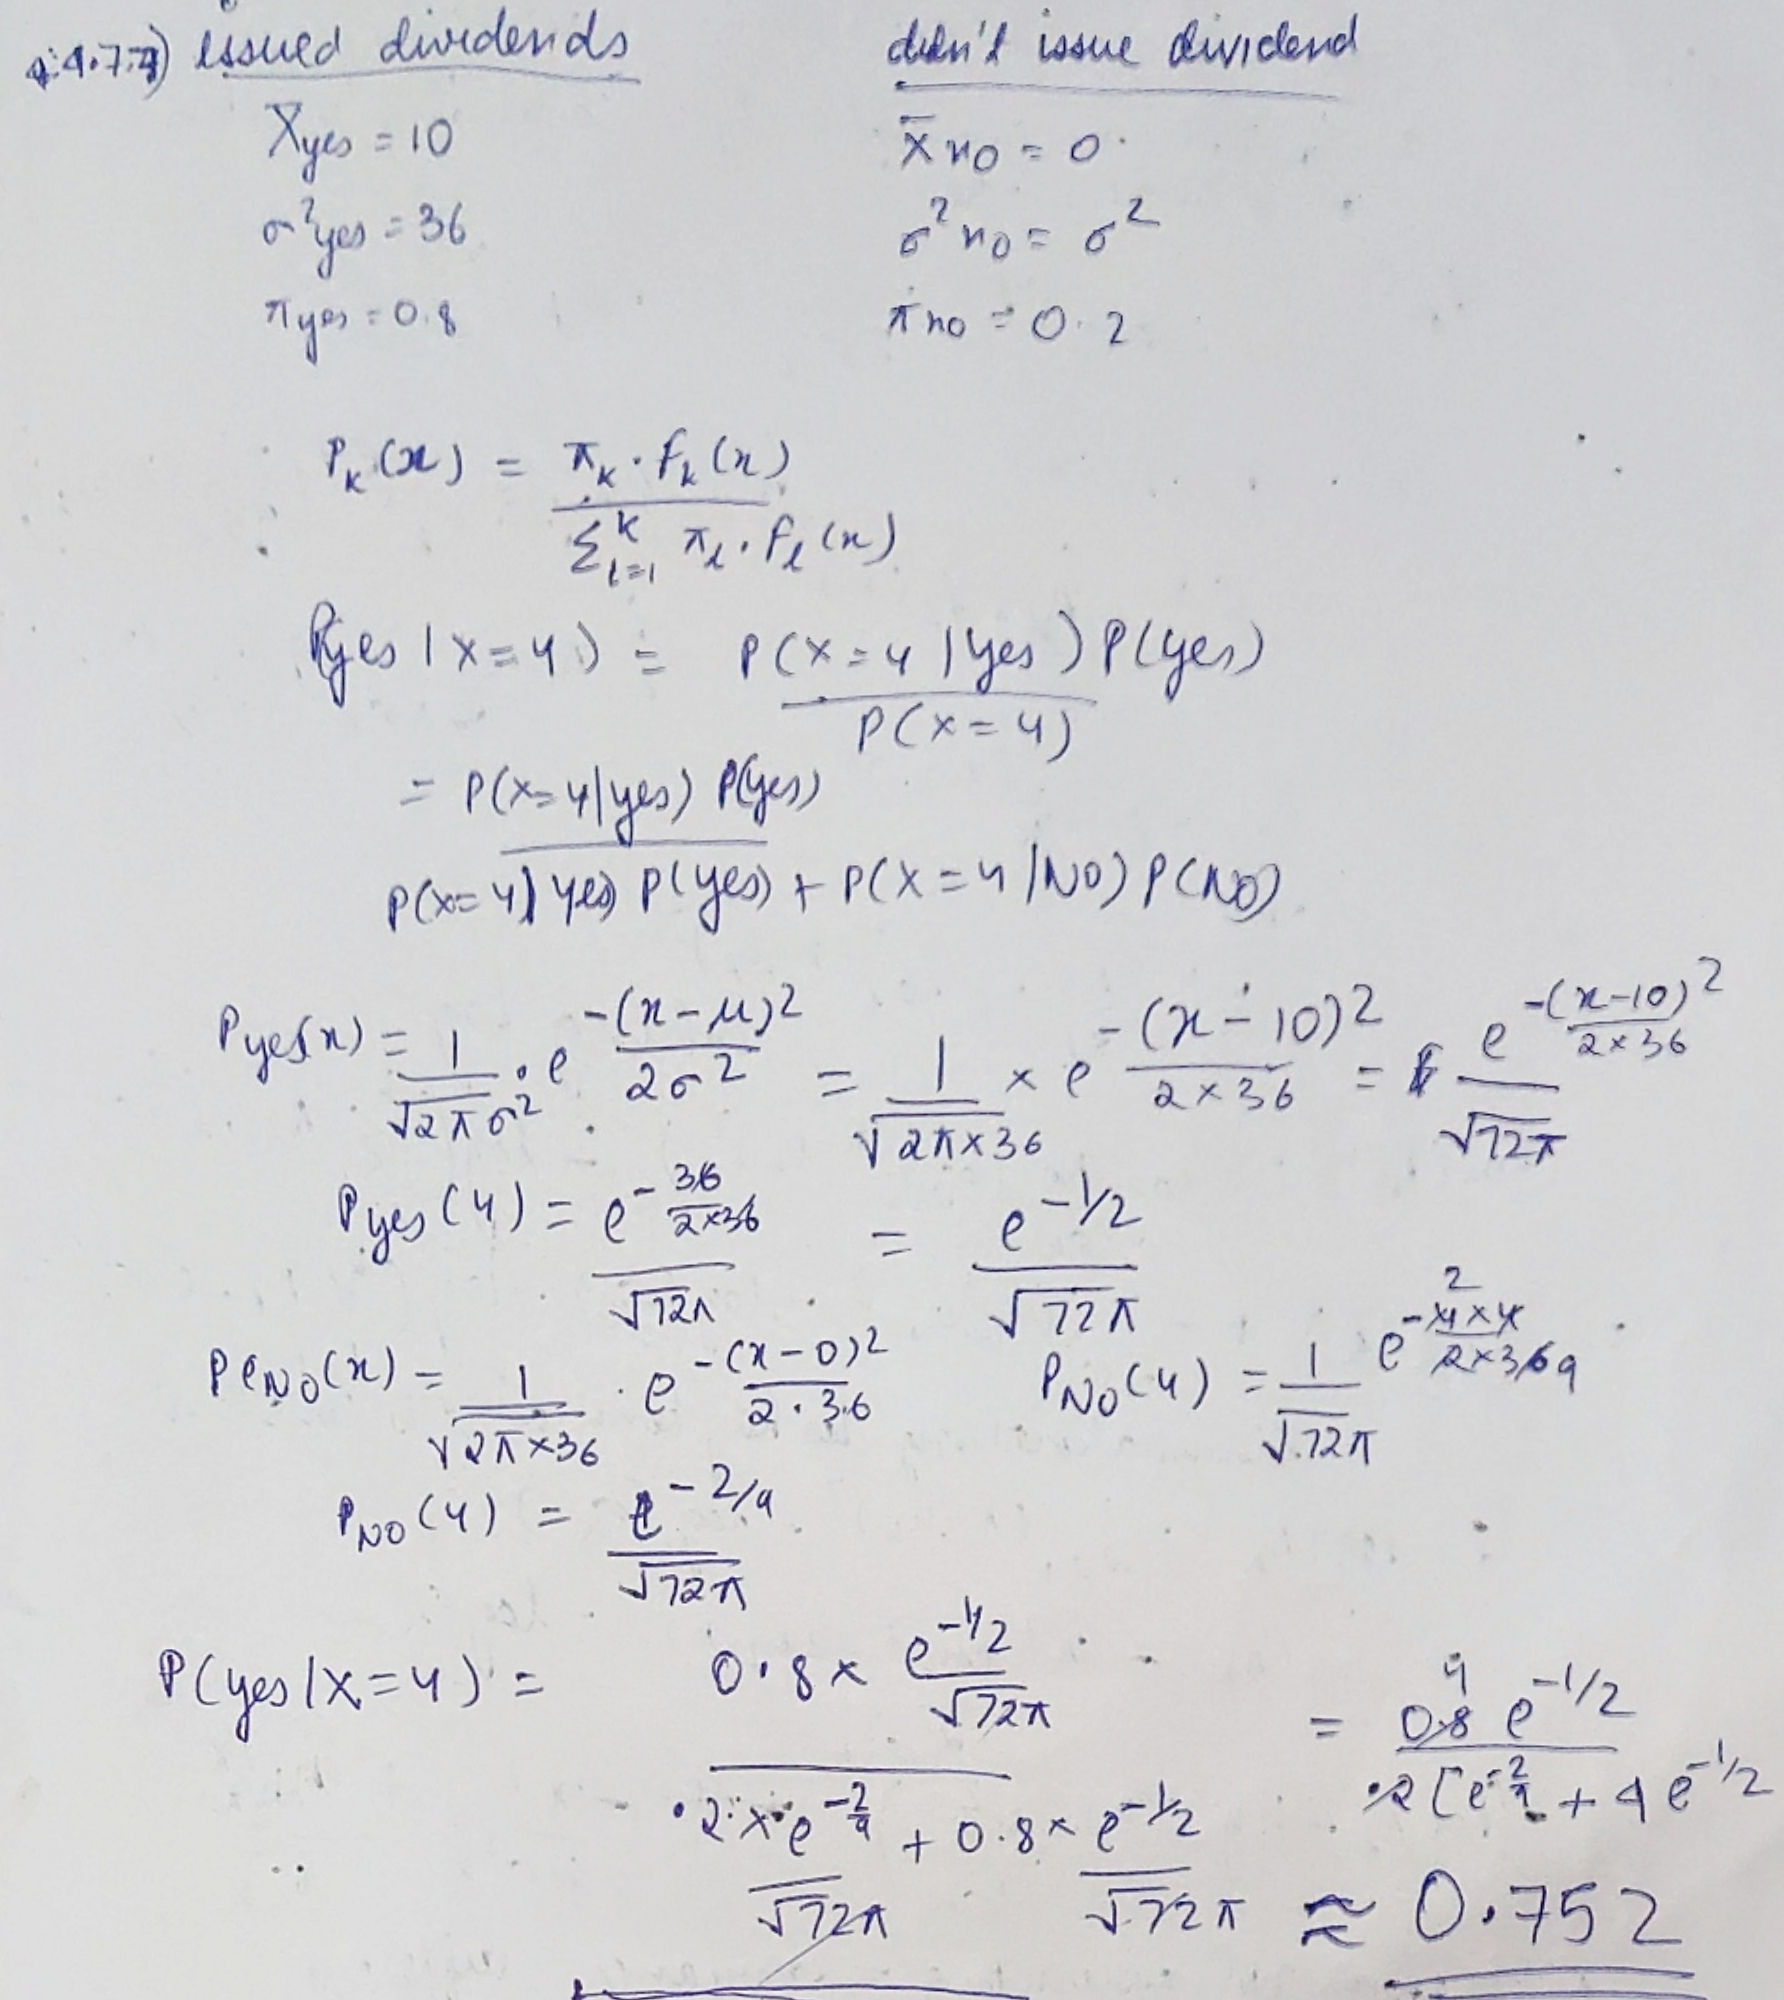

**References**

https://stackoverflow.com/questions/37796598/how-to-sort-file-names-in-a-particular-order-using-python
https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/
https://www.youtube.com/watch?v=J2TWB2OI_rs
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html